In [22]:
######## Imports ##########
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from xgboost.sklearn import XGBRegressor
import catboost as cb

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

from sklearn.model_selection import train_test_split
%matplotlib inline

In [2]:
######## Import data and show correlations ##########
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [3]:
train.describe()

,User_ID,Occupation,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase
count,5.500680e+05,550068.000000,550068.000000,550068.000000,376430.000000,166821.000000,550068.000000
mean,1.003029e+06,8.076707,0.409653,5.404270,9.842329,12.668243,9263.968713
std,1.727592e+03,6.522660,0.491770,3.936211,5.086590,4.125338,5023.065394
min,1.000001e+06,0.000000,0.000000,1.000000,2.000000,3.000000,12.000000
25%,1.001516e+06,2.000000,0.000000,1.000000,5.000000,9.000000,5823.000000
50%,1.003077e+06,7.000000,0.000000,5.000000,9.000000,14.000000,8047.000000
75%,1.004478e+06,14.000000,1.000000,8.000000,15.000000,16.000000,12054.000000
max,1.006040e+06,20.000000,1.000000,20.000000,18.000000,18.000000,23961.000000


In [12]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,User_ID_encoded,Product_ID_encoded
0,1000001,P00069042,0,0,10,0,2,0,3,0.0,0.0,8370,0,69042
1,1000001,P00248942,0,0,10,0,2,0,1,6.0,14.0,15200,0,248942
2,1000001,P00087842,0,0,10,0,2,0,12,0.0,0.0,1422,0,87842
3,1000001,P00085442,0,0,10,0,2,0,12,14.0,0.0,1057,0,85442
4,1000002,P00285442,1,6,16,2,4,0,8,0.0,0.0,7969,1,285442


In [5]:
train['User_ID_encoded'] = train['User_ID'] - 1000000
test['User_ID_encoded'] = test['User_ID'] - 1000000

enc = LabelEncoder()
train['User_ID_encoded'] = enc.fit_transform(train['User_ID_encoded'])
test['User_ID_encoded'] = enc.transform(test['User_ID_encoded'])

In [7]:
# Product_ID preprocess e.g. P00069042 -> 69042
train['Product_ID_encoded'] = train['Product_ID'].str.replace('P00', '')
train['Product_ID_encoded'] = train['Product_ID_encoded'].apply(lambda x: x.lstrip('0'))
train['Product_ID_encoded'] = pd.to_numeric(train['Product_ID_encoded'],errors='coerce')

test['Product_ID_encoded'] = test['Product_ID'].str.replace('P00', '')
test['Product_ID_encoded'] = test['Product_ID_encoded'].apply(lambda x: x.lstrip('0'))
test['Product_ID_encoded'] = pd.to_numeric(test['Product_ID_encoded'],errors='coerce')

In [9]:
var_mod = ['City_Category', 'Stay_In_Current_City_Years', 'Gender', 'Age']
le = LabelEncoder()
for i in var_mod:
    train[i] = le.fit_transform(train[i])
    test[i] = le.transform(test[i])

In [11]:
####### Fill missing product categories with most frequent values ########
#train['Product_Category_2'] = train.groupby('Product_Category_1')['Product_Category_2'].transform(lambda x: x.fillna(x.mode().values[0]) if x.mode().values.size != 0 else x.fillna(0))
#train['Product_Category_3'] = train.groupby(['Product_Category_2', 'Product_Category_1'])['Product_Category_3'].transform(lambda x: x.fillna(x.mode().values[0]) if x.mode().values.size != 0 else x.fillna(0))

#test['Product_Category_2'] = test.groupby('Product_Category_1')['Product_Category_2'].transform(lambda x: x.fillna(x.mode().values[0]) if x.mode().values.size != 0 else x.fillna(0))
#test['Product_Category_3'] = test.groupby(['Product_Category_2', 'Product_Category_1'])['Product_Category_3'].transform(lambda x: x.fillna(x.mode().values[0]) if x.mode().values.size != 0 else x.fillna(0))

train.fillna(0.0, inplace=True)
test.fillna(0.0, inplace=True)

In [8]:
train.head()

,User_ID,Product_ID,Gender,Age,Occupation,City_Category,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,Purchase,User_ID_encoded,Product_ID_encoded
0,1000001,P00069042,0,0,10,0,2,0,3,0.0,0.0,8370,0,69042
1,1000001,P00248942,0,0,10,0,2,0,1,6.0,14.0,15200,0,248942
2,1000001,P00087842,0,0,10,0,2,0,12,0.0,0.0,1422,0,87842
3,1000001,P00085442,0,0,10,0,2,0,12,14.0,0.0,1057,0,85442
4,1000002,P00285442,1,6,16,2,4,0,8,0.0,0.0,7969,1,285442


In [16]:
def validateModel(model):
    model.fit(x_train, y_train)
    train_pre = model.predict(x_train)
    test_pre = model.predict(x_test)
    
    print(model)
    print("RMSE: {0:.0f} \t Test RMSE: {1:.0f}".format(np.sqrt(mean_squared_error(y_train, train_pre)),np.sqrt(mean_squared_error(y_test,test_pre))))
    print()

In [17]:
validate = 'Purchase'
predictor_var = ['Product_Category_2', 'Product_Category_1', 'Product_Category_3', 'City_Category', 'Product_ID_encoded', 'Age', 'Stay_In_Current_City_Years', 'User_ID_encoded', "Occupation", 'Gender']

In [23]:
x_train, x_test, y_train, y_test = train_test_split(train[predictor_var], train[validate], test_size = 0.33, random_state=42)

In [28]:
####### Check different models ########
linreg = LinearRegression()
validateModel(linreg)

xgb_reg = XGBRegressor(random_state=42)
validateModel(xgb_reg)

gradB = GradientBoostingRegressor(random_state=42)
validateModel(gradB)

nn = MLPRegressor(random_state=42, hidden_layer_sizes=[64, 64, 64], max_iter = 2500)
validateModel(nn)

cat = cb.CatBoostRegressor(random_state=42, verbose=0)
validateModel(cat)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
RMSE: 4615.8454 	 Test RMSE: 4618.6533



/home/k/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bytree=1, gamma=0, importance_type='gain',
             learning_rate=0.1, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
             nthread=None, objective='reg:linear', random_state=42, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
             subsample=1)
RMSE: 2910.9427 	 Test RMSE: 2930.4387

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
                          learning_rate=0.1, loss='ls', max_depth=3,
                          max_features=None, max_leaf_nodes=None,
                          min_impurity_decrease=0.0, min_impurity_split=None,
                          min_samples_leaf=1, min_samples_split=2,
                          min_weight_fraction_leaf=0.0, n_estimators=100,
                          n_iter_no_change=None, presort='auto',
                 

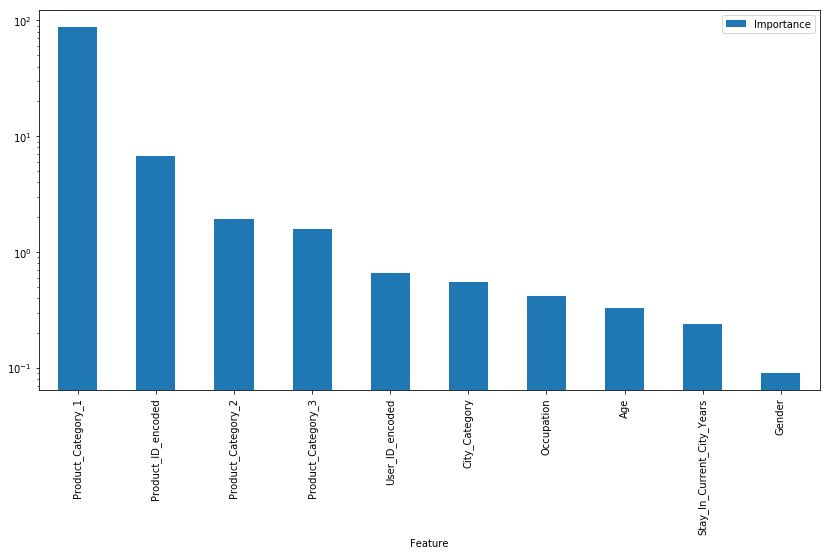

In [11]:
####### Print most important features ########

features = pd.DataFrame( {'Importance':cat.feature_importances_}, index=predictor_var)
features.index.name = 'Feature'
features.sort_values(by=['Importance'], ascending=False, inplace=True)
features.plot(kind='bar', logy=True, figsize=(14, 7))

In [12]:
####### Tuning best model without gender ########
predictor_var = ['Product_Category_2', 'Product_Category_1', 'Product_Category_3', 'City_Category', 'Product_ID_encoded', 'Age', 'Stay_In_Current_City_Years', 'User_ID_encoded', "Occupation", 'Gender']

param_grid = {
        "iterations": [1000],
        "learning_rate": [0.04],
        'depth': [11]
    }

tunned = tuneModel(cb.CatBoostRegressor(random_state=42), param_grid, train, predictor_var, outcome_var)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
/home/k/anaconda3/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning
[Parallel(n_jobs=-1)]: Done  13 out of  18 | elapsed: 210.3min remaining: 80.9min
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed: 244.2min finished


0:	learn: 10154.5760903	total: 84.4ms	remaining: 14m 3s
1:	learn: 9789.1483262	total: 146ms	remaining: 12m 7s
2:	learn: 9442.0799203	total: 217ms	remaining: 12m 3s
3:	learn: 9106.6054091	total: 291ms	remaining: 12m 6s
4:	learn: 8791.4662136	total: 373ms	remaining: 12m 25s
5:	learn: 8494.7669752	total: 446ms	remaining: 12m 22s
6:	learn: 8201.3761548	total: 523ms	remaining: 12m 26s
7:	learn: 7921.1825661	total: 580ms	remaining: 12m 4s
8:	learn: 7654.5834005	total: 651ms	remaining: 12m 2s
9:	learn: 7399.9683498	total: 721ms	remaining: 12m
10:	learn: 7160.8500284	total: 804ms	remaining: 12m 10s
11:	learn: 6932.7477413	total: 880ms	remaining: 12m 12s
12:	learn: 6710.3053027	total: 951ms	remaining: 12m 10s
13:	learn: 6503.3125857	total: 1.03s	remaining: 12m 16s
14:	learn: 6304.0897970	total: 1.11s	remaining: 12m 16s
15:	learn: 6111.0381072	total: 1.18s	remaining: 12m 16s
16:	learn: 5932.2665745	total: 1.25s	remaining: 12m 16s
17:	learn: 5762.7176635	total: 1.33s	remaining: 12m 19s
18:	learn:

148:	learn: 2833.8161643	total: 11.4s	remaining: 12m 31s
149:	learn: 2832.9116328	total: 11.4s	remaining: 12m 30s
150:	learn: 2832.1408106	total: 11.5s	remaining: 12m 30s
151:	learn: 2831.0422703	total: 11.6s	remaining: 12m 30s
152:	learn: 2830.1050333	total: 11.7s	remaining: 12m 30s
153:	learn: 2828.8183028	total: 11.7s	remaining: 12m 30s
154:	learn: 2827.5109961	total: 11.8s	remaining: 12m 30s
155:	learn: 2826.7359000	total: 11.9s	remaining: 12m 30s
156:	learn: 2825.3558446	total: 12s	remaining: 12m 30s
157:	learn: 2824.3593180	total: 12.1s	remaining: 12m 30s
158:	learn: 2823.4335152	total: 12.1s	remaining: 12m 30s
159:	learn: 2822.4835498	total: 12.2s	remaining: 12m 30s
160:	learn: 2821.4495586	total: 12.3s	remaining: 12m 30s
161:	learn: 2820.5094141	total: 12.4s	remaining: 12m 30s
162:	learn: 2819.7763174	total: 12.4s	remaining: 12m 30s
163:	learn: 2818.9480001	total: 12.5s	remaining: 12m 29s
164:	learn: 2818.2953716	total: 12.6s	remaining: 12m 29s
165:	learn: 2817.4423507	total: 1

295:	learn: 2736.7095663	total: 22.6s	remaining: 12m 21s
296:	learn: 2736.0390039	total: 22.7s	remaining: 12m 21s
297:	learn: 2735.5903665	total: 22.8s	remaining: 12m 21s
298:	learn: 2735.0116566	total: 22.8s	remaining: 12m 21s
299:	learn: 2734.5964638	total: 22.9s	remaining: 12m 21s
300:	learn: 2734.0157718	total: 23s	remaining: 12m 21s
301:	learn: 2733.5130796	total: 23.1s	remaining: 12m 20s
302:	learn: 2732.9138798	total: 23.1s	remaining: 12m 20s
303:	learn: 2732.2824827	total: 23.2s	remaining: 12m 20s
304:	learn: 2731.7527170	total: 23.3s	remaining: 12m 20s
305:	learn: 2731.3928908	total: 23.4s	remaining: 12m 20s
306:	learn: 2731.0878670	total: 23.5s	remaining: 12m 20s
307:	learn: 2730.7892549	total: 23.5s	remaining: 12m 20s
308:	learn: 2730.2355035	total: 23.6s	remaining: 12m 20s
309:	learn: 2729.5849265	total: 23.7s	remaining: 12m 20s
310:	learn: 2729.1629739	total: 23.8s	remaining: 12m 20s
311:	learn: 2728.6614785	total: 23.8s	remaining: 12m 19s
312:	learn: 2728.2675334	total: 2

442:	learn: 2679.8008805	total: 33.8s	remaining: 12m 9s
443:	learn: 2679.4725824	total: 33.9s	remaining: 12m 9s
444:	learn: 2679.2140555	total: 34s	remaining: 12m 9s
445:	learn: 2678.9933281	total: 34s	remaining: 12m 9s
446:	learn: 2678.7808058	total: 34.1s	remaining: 12m 9s
447:	learn: 2678.4030901	total: 34.2s	remaining: 12m 8s
448:	learn: 2678.1766864	total: 34.3s	remaining: 12m 8s
449:	learn: 2677.8649936	total: 34.3s	remaining: 12m 8s
450:	learn: 2677.5421100	total: 34.4s	remaining: 12m 8s
451:	learn: 2677.3076151	total: 34.5s	remaining: 12m 8s
452:	learn: 2676.8213283	total: 34.6s	remaining: 12m 8s
453:	learn: 2676.6082677	total: 34.6s	remaining: 12m 8s
454:	learn: 2676.0266182	total: 34.7s	remaining: 12m 8s
455:	learn: 2675.6760476	total: 34.8s	remaining: 12m 8s
456:	learn: 2675.4505530	total: 34.9s	remaining: 12m 8s
457:	learn: 2674.9896031	total: 35s	remaining: 12m 8s
458:	learn: 2674.7228212	total: 35s	remaining: 12m 8s
459:	learn: 2674.4763439	total: 35.1s	remaining: 12m 8s


589:	learn: 2638.4792785	total: 45.2s	remaining: 12m 1s
590:	learn: 2638.1979910	total: 45.3s	remaining: 12m 1s
591:	learn: 2637.9615104	total: 45.4s	remaining: 12m
592:	learn: 2637.7964064	total: 45.4s	remaining: 12m
593:	learn: 2637.3982158	total: 45.5s	remaining: 12m
594:	learn: 2637.2826066	total: 45.6s	remaining: 12m
595:	learn: 2637.0033827	total: 45.7s	remaining: 12m
596:	learn: 2636.8608147	total: 45.8s	remaining: 12m
597:	learn: 2636.6722990	total: 45.8s	remaining: 12m
598:	learn: 2636.3231835	total: 45.9s	remaining: 12m
599:	learn: 2636.1610715	total: 46s	remaining: 12m
600:	learn: 2635.9526315	total: 46.1s	remaining: 12m
601:	learn: 2635.6739450	total: 46.1s	remaining: 12m
602:	learn: 2635.3974368	total: 46.2s	remaining: 12m
603:	learn: 2635.2344185	total: 46.3s	remaining: 12m
604:	learn: 2635.1006907	total: 46.4s	remaining: 12m
605:	learn: 2634.8312522	total: 46.4s	remaining: 12m
606:	learn: 2634.6097077	total: 46.5s	remaining: 11m 59s
607:	learn: 2634.4509858	total: 46.6s	

736:	learn: 2605.9593105	total: 56.5s	remaining: 11m 50s
737:	learn: 2605.7678737	total: 56.6s	remaining: 11m 50s
738:	learn: 2605.4631399	total: 56.7s	remaining: 11m 50s
739:	learn: 2605.2388917	total: 56.8s	remaining: 11m 50s
740:	learn: 2605.0587529	total: 56.8s	remaining: 11m 50s
741:	learn: 2604.8018042	total: 56.9s	remaining: 11m 50s
742:	learn: 2604.6440656	total: 57s	remaining: 11m 49s
743:	learn: 2604.4656439	total: 57.1s	remaining: 11m 49s
744:	learn: 2604.2066079	total: 57.1s	remaining: 11m 49s
745:	learn: 2603.8917860	total: 57.2s	remaining: 11m 49s
746:	learn: 2603.6408629	total: 57.3s	remaining: 11m 49s
747:	learn: 2603.3467116	total: 57.4s	remaining: 11m 49s
748:	learn: 2603.1041869	total: 57.5s	remaining: 11m 49s
749:	learn: 2602.8568189	total: 57.5s	remaining: 11m 49s
750:	learn: 2602.7345208	total: 57.6s	remaining: 11m 49s
751:	learn: 2602.5825167	total: 57.7s	remaining: 11m 49s
752:	learn: 2602.3560628	total: 57.8s	remaining: 11m 49s
753:	learn: 2602.2434734	total: 5

883:	learn: 2578.2855833	total: 1m 7s	remaining: 11m 38s
884:	learn: 2578.1515690	total: 1m 7s	remaining: 11m 38s
885:	learn: 2577.9175336	total: 1m 7s	remaining: 11m 38s
886:	learn: 2577.7588060	total: 1m 8s	remaining: 11m 38s
887:	learn: 2577.6209686	total: 1m 8s	remaining: 11m 38s
888:	learn: 2577.4358215	total: 1m 8s	remaining: 11m 38s
889:	learn: 2577.3469829	total: 1m 8s	remaining: 11m 38s
890:	learn: 2577.2547673	total: 1m 8s	remaining: 11m 38s
891:	learn: 2577.0428475	total: 1m 8s	remaining: 11m 38s
892:	learn: 2576.8897010	total: 1m 8s	remaining: 11m 38s
893:	learn: 2576.6398389	total: 1m 8s	remaining: 11m 38s
894:	learn: 2576.4977931	total: 1m 8s	remaining: 11m 38s
895:	learn: 2576.3249793	total: 1m 8s	remaining: 11m 38s
896:	learn: 2576.1526751	total: 1m 8s	remaining: 11m 37s
897:	learn: 2575.8567910	total: 1m 8s	remaining: 11m 37s
898:	learn: 2575.7192168	total: 1m 8s	remaining: 11m 37s
899:	learn: 2575.4490086	total: 1m 9s	remaining: 11m 37s
900:	learn: 2575.2904495	total:

1027:	learn: 2553.6565188	total: 1m 19s	remaining: 11m 33s
1028:	learn: 2553.5031609	total: 1m 19s	remaining: 11m 33s
1029:	learn: 2553.3567151	total: 1m 19s	remaining: 11m 33s
1030:	learn: 2553.1056630	total: 1m 19s	remaining: 11m 33s
1031:	learn: 2552.8809064	total: 1m 19s	remaining: 11m 33s
1032:	learn: 2552.7068095	total: 1m 19s	remaining: 11m 33s
1033:	learn: 2552.5975376	total: 1m 19s	remaining: 11m 33s
1034:	learn: 2552.4618895	total: 1m 20s	remaining: 11m 33s
1035:	learn: 2552.3854269	total: 1m 20s	remaining: 11m 32s
1036:	learn: 2552.2608569	total: 1m 20s	remaining: 11m 32s
1037:	learn: 2552.1282501	total: 1m 20s	remaining: 11m 32s
1038:	learn: 2552.0038863	total: 1m 20s	remaining: 11m 32s
1039:	learn: 2551.8061031	total: 1m 20s	remaining: 11m 32s
1040:	learn: 2551.5978147	total: 1m 20s	remaining: 11m 32s
1041:	learn: 2551.4910458	total: 1m 20s	remaining: 11m 32s
1042:	learn: 2551.2942116	total: 1m 20s	remaining: 11m 32s
1043:	learn: 2551.1428305	total: 1m 20s	remaining: 11m 3

1166:	learn: 2532.7372484	total: 1m 30s	remaining: 11m 25s
1167:	learn: 2532.6424998	total: 1m 30s	remaining: 11m 25s
1168:	learn: 2532.4809550	total: 1m 30s	remaining: 11m 24s
1169:	learn: 2532.2932902	total: 1m 30s	remaining: 11m 24s
1170:	learn: 2532.1149261	total: 1m 30s	remaining: 11m 24s
1171:	learn: 2531.9365805	total: 1m 30s	remaining: 11m 24s
1172:	learn: 2531.7681509	total: 1m 30s	remaining: 11m 24s
1173:	learn: 2531.6801529	total: 1m 31s	remaining: 11m 24s
1174:	learn: 2531.5644738	total: 1m 31s	remaining: 11m 24s
1175:	learn: 2531.4656492	total: 1m 31s	remaining: 11m 24s
1176:	learn: 2531.4057785	total: 1m 31s	remaining: 11m 24s
1177:	learn: 2531.2612386	total: 1m 31s	remaining: 11m 24s
1178:	learn: 2531.1134622	total: 1m 31s	remaining: 11m 24s
1179:	learn: 2531.0092507	total: 1m 31s	remaining: 11m 24s
1180:	learn: 2530.8801332	total: 1m 31s	remaining: 11m 24s
1181:	learn: 2530.7602032	total: 1m 31s	remaining: 11m 23s
1182:	learn: 2530.6296848	total: 1m 31s	remaining: 11m 2

1307:	learn: 2512.6962262	total: 1m 41s	remaining: 11m 13s
1308:	learn: 2512.5248225	total: 1m 41s	remaining: 11m 13s
1309:	learn: 2512.3324938	total: 1m 41s	remaining: 11m 13s
1310:	learn: 2512.2081359	total: 1m 41s	remaining: 11m 13s
1311:	learn: 2512.1022891	total: 1m 41s	remaining: 11m 13s
1312:	learn: 2511.9745258	total: 1m 41s	remaining: 11m 13s
1313:	learn: 2511.8226447	total: 1m 41s	remaining: 11m 13s
1314:	learn: 2511.6986712	total: 1m 41s	remaining: 11m 13s
1315:	learn: 2511.5702356	total: 1m 41s	remaining: 11m 12s
1316:	learn: 2511.4767514	total: 1m 42s	remaining: 11m 12s
1317:	learn: 2511.3925171	total: 1m 42s	remaining: 11m 12s
1318:	learn: 2511.3164083	total: 1m 42s	remaining: 11m 12s
1319:	learn: 2511.2326658	total: 1m 42s	remaining: 11m 12s
1320:	learn: 2511.0731286	total: 1m 42s	remaining: 11m 12s
1321:	learn: 2510.9613159	total: 1m 42s	remaining: 11m 12s
1322:	learn: 2510.8364059	total: 1m 42s	remaining: 11m 12s
1323:	learn: 2510.7299634	total: 1m 42s	remaining: 11m 1

1448:	learn: 2494.2090046	total: 1m 52s	remaining: 11m 2s
1449:	learn: 2494.0452964	total: 1m 52s	remaining: 11m 2s
1450:	learn: 2494.0103709	total: 1m 52s	remaining: 11m 2s
1451:	learn: 2493.8373620	total: 1m 52s	remaining: 11m 2s
1452:	learn: 2493.7400312	total: 1m 52s	remaining: 11m 1s
1453:	learn: 2493.5945305	total: 1m 52s	remaining: 11m 1s
1454:	learn: 2493.4286500	total: 1m 52s	remaining: 11m 1s
1455:	learn: 2493.3414199	total: 1m 52s	remaining: 11m 1s
1456:	learn: 2493.2071062	total: 1m 52s	remaining: 11m 1s
1457:	learn: 2493.0642354	total: 1m 52s	remaining: 11m 1s
1458:	learn: 2492.9110585	total: 1m 52s	remaining: 11m 1s
1459:	learn: 2492.7280725	total: 1m 53s	remaining: 11m 1s
1460:	learn: 2492.6108344	total: 1m 53s	remaining: 11m 1s
1461:	learn: 2492.5383400	total: 1m 53s	remaining: 11m 1s
1462:	learn: 2492.4172436	total: 1m 53s	remaining: 11m 1s
1463:	learn: 2492.3214372	total: 1m 53s	remaining: 11m 1s
1464:	learn: 2492.1266104	total: 1m 53s	remaining: 11m
1465:	learn: 2492

1592:	learn: 2476.8345970	total: 2m 3s	remaining: 10m 50s
1593:	learn: 2476.7047329	total: 2m 3s	remaining: 10m 50s
1594:	learn: 2476.6032626	total: 2m 3s	remaining: 10m 50s
1595:	learn: 2476.5405592	total: 2m 3s	remaining: 10m 50s
1596:	learn: 2476.3905043	total: 2m 3s	remaining: 10m 50s
1597:	learn: 2476.3099293	total: 2m 3s	remaining: 10m 50s
1598:	learn: 2476.2015066	total: 2m 3s	remaining: 10m 50s
1599:	learn: 2476.0874058	total: 2m 3s	remaining: 10m 50s
1600:	learn: 2476.0207924	total: 2m 3s	remaining: 10m 50s
1601:	learn: 2475.8591120	total: 2m 4s	remaining: 10m 50s
1602:	learn: 2475.7134171	total: 2m 4s	remaining: 10m 49s
1603:	learn: 2475.6306274	total: 2m 4s	remaining: 10m 49s
1604:	learn: 2475.5072624	total: 2m 4s	remaining: 10m 49s
1605:	learn: 2475.3786748	total: 2m 4s	remaining: 10m 49s
1606:	learn: 2475.2892581	total: 2m 4s	remaining: 10m 49s
1607:	learn: 2475.1726641	total: 2m 4s	remaining: 10m 49s
1608:	learn: 2475.0687861	total: 2m 4s	remaining: 10m 49s
1609:	learn: 2

1733:	learn: 2460.9972269	total: 2m 14s	remaining: 10m 39s
1734:	learn: 2460.8737427	total: 2m 14s	remaining: 10m 39s
1735:	learn: 2460.7794329	total: 2m 14s	remaining: 10m 39s
1736:	learn: 2460.6969039	total: 2m 14s	remaining: 10m 39s
1737:	learn: 2460.5736732	total: 2m 14s	remaining: 10m 39s
1738:	learn: 2460.4358515	total: 2m 14s	remaining: 10m 38s
1739:	learn: 2460.3160291	total: 2m 14s	remaining: 10m 38s
1740:	learn: 2460.2097989	total: 2m 14s	remaining: 10m 38s
1741:	learn: 2460.1020650	total: 2m 14s	remaining: 10m 38s
1742:	learn: 2459.9934500	total: 2m 14s	remaining: 10m 38s
1743:	learn: 2459.8628210	total: 2m 14s	remaining: 10m 38s
1744:	learn: 2459.7520666	total: 2m 14s	remaining: 10m 38s
1745:	learn: 2459.6667837	total: 2m 15s	remaining: 10m 38s
1746:	learn: 2459.5353997	total: 2m 15s	remaining: 10m 38s
1747:	learn: 2459.3639910	total: 2m 15s	remaining: 10m 38s
1748:	learn: 2459.2777850	total: 2m 15s	remaining: 10m 38s
1749:	learn: 2459.2025418	total: 2m 15s	remaining: 10m 3

1874:	learn: 2445.2576987	total: 2m 24s	remaining: 10m 28s
1875:	learn: 2445.1493711	total: 2m 25s	remaining: 10m 28s
1876:	learn: 2445.0698966	total: 2m 25s	remaining: 10m 28s
1877:	learn: 2444.9731566	total: 2m 25s	remaining: 10m 27s
1878:	learn: 2444.8406148	total: 2m 25s	remaining: 10m 27s
1879:	learn: 2444.7380765	total: 2m 25s	remaining: 10m 27s
1880:	learn: 2444.6051894	total: 2m 25s	remaining: 10m 27s
1881:	learn: 2444.5375669	total: 2m 25s	remaining: 10m 27s
1882:	learn: 2444.4055579	total: 2m 25s	remaining: 10m 27s
1883:	learn: 2444.3310413	total: 2m 25s	remaining: 10m 27s
1884:	learn: 2444.2631011	total: 2m 25s	remaining: 10m 27s
1885:	learn: 2444.1438806	total: 2m 25s	remaining: 10m 27s
1886:	learn: 2444.0909722	total: 2m 25s	remaining: 10m 27s
1887:	learn: 2443.8922252	total: 2m 25s	remaining: 10m 27s
1888:	learn: 2443.7959394	total: 2m 26s	remaining: 10m 27s
1889:	learn: 2443.7292446	total: 2m 26s	remaining: 10m 27s
1890:	learn: 2443.6187717	total: 2m 26s	remaining: 10m 2

2015:	learn: 2430.2368001	total: 2m 36s	remaining: 10m 17s
2016:	learn: 2430.1681788	total: 2m 36s	remaining: 10m 17s
2017:	learn: 2430.0424859	total: 2m 36s	remaining: 10m 17s
2018:	learn: 2429.9339539	total: 2m 36s	remaining: 10m 17s
2019:	learn: 2429.8401633	total: 2m 36s	remaining: 10m 17s
2020:	learn: 2429.7352985	total: 2m 36s	remaining: 10m 17s
2021:	learn: 2429.6365247	total: 2m 36s	remaining: 10m 17s
2022:	learn: 2429.5452128	total: 2m 36s	remaining: 10m 17s
2023:	learn: 2429.4324128	total: 2m 36s	remaining: 10m 17s
2024:	learn: 2429.3159335	total: 2m 36s	remaining: 10m 17s
2025:	learn: 2429.1823891	total: 2m 36s	remaining: 10m 17s
2026:	learn: 2429.0748198	total: 2m 36s	remaining: 10m 17s
2027:	learn: 2429.0154808	total: 2m 37s	remaining: 10m 17s
2028:	learn: 2428.8991745	total: 2m 37s	remaining: 10m 17s
2029:	learn: 2428.8060508	total: 2m 37s	remaining: 10m 17s
2030:	learn: 2428.7512473	total: 2m 37s	remaining: 10m 17s
2031:	learn: 2428.6164840	total: 2m 37s	remaining: 10m 1

2155:	learn: 2416.2289711	total: 2m 47s	remaining: 10m 8s
2156:	learn: 2416.1178531	total: 2m 47s	remaining: 10m 8s
2157:	learn: 2416.0041970	total: 2m 47s	remaining: 10m 8s
2158:	learn: 2415.9395879	total: 2m 47s	remaining: 10m 8s
2159:	learn: 2415.8035758	total: 2m 47s	remaining: 10m 8s
2160:	learn: 2415.6603205	total: 2m 47s	remaining: 10m 8s
2161:	learn: 2415.6082048	total: 2m 47s	remaining: 10m 8s
2162:	learn: 2415.4792275	total: 2m 47s	remaining: 10m 8s
2163:	learn: 2415.3531103	total: 2m 47s	remaining: 10m 8s
2164:	learn: 2415.2193613	total: 2m 48s	remaining: 10m 7s
2165:	learn: 2415.1269907	total: 2m 48s	remaining: 10m 7s
2166:	learn: 2415.0206699	total: 2m 48s	remaining: 10m 7s
2167:	learn: 2414.9272378	total: 2m 48s	remaining: 10m 7s
2168:	learn: 2414.8323539	total: 2m 48s	remaining: 10m 7s
2169:	learn: 2414.7202045	total: 2m 48s	remaining: 10m 7s
2170:	learn: 2414.6559865	total: 2m 48s	remaining: 10m 7s
2171:	learn: 2414.5703728	total: 2m 48s	remaining: 10m 7s
2172:	learn: 2

2299:	learn: 2402.3715080	total: 2m 58s	remaining: 9m 58s
2300:	learn: 2402.2900593	total: 2m 58s	remaining: 9m 58s
2301:	learn: 2402.1804439	total: 2m 58s	remaining: 9m 58s
2302:	learn: 2402.0924967	total: 2m 59s	remaining: 9m 58s
2303:	learn: 2402.0086308	total: 2m 59s	remaining: 9m 58s
2304:	learn: 2401.9205517	total: 2m 59s	remaining: 9m 58s
2305:	learn: 2401.8056124	total: 2m 59s	remaining: 9m 58s
2306:	learn: 2401.7073028	total: 2m 59s	remaining: 9m 58s
2307:	learn: 2401.6034425	total: 2m 59s	remaining: 9m 57s
2308:	learn: 2401.4900929	total: 2m 59s	remaining: 9m 57s
2309:	learn: 2401.4115780	total: 2m 59s	remaining: 9m 57s
2310:	learn: 2401.3226554	total: 2m 59s	remaining: 9m 57s
2311:	learn: 2401.2372548	total: 2m 59s	remaining: 9m 57s
2312:	learn: 2401.1523445	total: 2m 59s	remaining: 9m 57s
2313:	learn: 2401.0729147	total: 2m 59s	remaining: 9m 57s
2314:	learn: 2401.0112222	total: 2m 59s	remaining: 9m 57s
2315:	learn: 2400.9116874	total: 3m	remaining: 9m 57s
2316:	learn: 2400.

2446:	learn: 2389.0129939	total: 3m 10s	remaining: 9m 47s
2447:	learn: 2388.9151959	total: 3m 10s	remaining: 9m 47s
2448:	learn: 2388.7758275	total: 3m 10s	remaining: 9m 47s
2449:	learn: 2388.7026333	total: 3m 10s	remaining: 9m 47s
2450:	learn: 2388.6496735	total: 3m 10s	remaining: 9m 47s
2451:	learn: 2388.5783087	total: 3m 10s	remaining: 9m 47s
2452:	learn: 2388.4790461	total: 3m 10s	remaining: 9m 47s
2453:	learn: 2388.3869283	total: 3m 10s	remaining: 9m 47s
2454:	learn: 2388.3037679	total: 3m 11s	remaining: 9m 47s
2455:	learn: 2388.1982728	total: 3m 11s	remaining: 9m 47s
2456:	learn: 2388.0967240	total: 3m 11s	remaining: 9m 47s
2457:	learn: 2387.9988736	total: 3m 11s	remaining: 9m 47s
2458:	learn: 2387.9037836	total: 3m 11s	remaining: 9m 46s
2459:	learn: 2387.7740162	total: 3m 11s	remaining: 9m 46s
2460:	learn: 2387.6654725	total: 3m 11s	remaining: 9m 46s
2461:	learn: 2387.5806705	total: 3m 11s	remaining: 9m 46s
2462:	learn: 2387.4692693	total: 3m 11s	remaining: 9m 46s
2463:	learn: 2

2589:	learn: 2375.9372980	total: 3m 21s	remaining: 9m 37s
2590:	learn: 2375.8525374	total: 3m 21s	remaining: 9m 37s
2591:	learn: 2375.7477232	total: 3m 22s	remaining: 9m 37s
2592:	learn: 2375.6703868	total: 3m 22s	remaining: 9m 37s
2593:	learn: 2375.5937108	total: 3m 22s	remaining: 9m 37s
2594:	learn: 2375.5293234	total: 3m 22s	remaining: 9m 37s
2595:	learn: 2375.4546934	total: 3m 22s	remaining: 9m 37s
2596:	learn: 2375.3990966	total: 3m 22s	remaining: 9m 37s
2597:	learn: 2375.3450497	total: 3m 22s	remaining: 9m 36s
2598:	learn: 2375.2917235	total: 3m 22s	remaining: 9m 36s
2599:	learn: 2375.1922270	total: 3m 22s	remaining: 9m 36s
2600:	learn: 2375.1052564	total: 3m 22s	remaining: 9m 36s
2601:	learn: 2374.9945322	total: 3m 22s	remaining: 9m 36s
2602:	learn: 2374.9182371	total: 3m 22s	remaining: 9m 36s
2603:	learn: 2374.8355412	total: 3m 22s	remaining: 9m 36s
2604:	learn: 2374.7358206	total: 3m 23s	remaining: 9m 36s
2605:	learn: 2374.6477773	total: 3m 23s	remaining: 9m 36s
2606:	learn: 2

2733:	learn: 2363.7718944	total: 3m 33s	remaining: 9m 26s
2734:	learn: 2363.6903068	total: 3m 33s	remaining: 9m 26s
2735:	learn: 2363.6273367	total: 3m 33s	remaining: 9m 25s
2736:	learn: 2363.5404812	total: 3m 33s	remaining: 9m 25s
2737:	learn: 2363.4808795	total: 3m 33s	remaining: 9m 25s
2738:	learn: 2363.4217605	total: 3m 33s	remaining: 9m 25s
2739:	learn: 2363.3590182	total: 3m 33s	remaining: 9m 25s
2740:	learn: 2363.2942496	total: 3m 33s	remaining: 9m 25s
2741:	learn: 2363.2189636	total: 3m 33s	remaining: 9m 25s
2742:	learn: 2363.1453871	total: 3m 33s	remaining: 9m 25s
2743:	learn: 2363.0244178	total: 3m 33s	remaining: 9m 25s
2744:	learn: 2362.9323136	total: 3m 33s	remaining: 9m 25s
2745:	learn: 2362.8610579	total: 3m 33s	remaining: 9m 25s
2746:	learn: 2362.7696395	total: 3m 34s	remaining: 9m 25s
2747:	learn: 2362.6884105	total: 3m 34s	remaining: 9m 24s
2748:	learn: 2362.5778064	total: 3m 34s	remaining: 9m 24s
2749:	learn: 2362.4457981	total: 3m 34s	remaining: 9m 24s
2750:	learn: 2

2877:	learn: 2351.5912275	total: 3m 44s	remaining: 9m 14s
2878:	learn: 2351.5015958	total: 3m 44s	remaining: 9m 14s
2879:	learn: 2351.4336544	total: 3m 44s	remaining: 9m 14s
2880:	learn: 2351.3650232	total: 3m 44s	remaining: 9m 14s
2881:	learn: 2351.3014163	total: 3m 44s	remaining: 9m 14s
2882:	learn: 2351.2421509	total: 3m 44s	remaining: 9m 14s
2883:	learn: 2351.1585464	total: 3m 44s	remaining: 9m 14s
2884:	learn: 2351.0802411	total: 3m 44s	remaining: 9m 14s
2885:	learn: 2350.9725535	total: 3m 44s	remaining: 9m 14s
2886:	learn: 2350.8980994	total: 3m 44s	remaining: 9m 13s
2887:	learn: 2350.8037883	total: 3m 44s	remaining: 9m 13s
2888:	learn: 2350.7338734	total: 3m 44s	remaining: 9m 13s
2889:	learn: 2350.6476966	total: 3m 45s	remaining: 9m 13s
2890:	learn: 2350.5461000	total: 3m 45s	remaining: 9m 13s
2891:	learn: 2350.4461138	total: 3m 45s	remaining: 9m 13s
2892:	learn: 2350.3726481	total: 3m 45s	remaining: 9m 13s
2893:	learn: 2350.2990577	total: 3m 45s	remaining: 9m 13s
2894:	learn: 2

3021:	learn: 2339.9219802	total: 3m 55s	remaining: 9m 3s
3022:	learn: 2339.8669949	total: 3m 55s	remaining: 9m 3s
3023:	learn: 2339.8036909	total: 3m 55s	remaining: 9m 3s
3024:	learn: 2339.7456145	total: 3m 55s	remaining: 9m 3s
3025:	learn: 2339.6675228	total: 3m 55s	remaining: 9m 2s
3026:	learn: 2339.6105505	total: 3m 55s	remaining: 9m 2s
3027:	learn: 2339.5223713	total: 3m 55s	remaining: 9m 2s
3028:	learn: 2339.4460922	total: 3m 55s	remaining: 9m 2s
3029:	learn: 2339.3848978	total: 3m 55s	remaining: 9m 2s
3030:	learn: 2339.3080601	total: 3m 55s	remaining: 9m 2s
3031:	learn: 2339.2434953	total: 3m 56s	remaining: 9m 2s
3032:	learn: 2339.1676322	total: 3m 56s	remaining: 9m 2s
3033:	learn: 2339.0675588	total: 3m 56s	remaining: 9m 2s
3034:	learn: 2338.9813398	total: 3m 56s	remaining: 9m 2s
3035:	learn: 2338.8892200	total: 3m 56s	remaining: 9m 2s
3036:	learn: 2338.8272364	total: 3m 56s	remaining: 9m 2s
3037:	learn: 2338.7557693	total: 3m 56s	remaining: 9m 2s
3038:	learn: 2338.6855222	total

3168:	learn: 2328.5666044	total: 4m 6s	remaining: 8m 51s
3169:	learn: 2328.5139271	total: 4m 6s	remaining: 8m 51s
3170:	learn: 2328.4491183	total: 4m 6s	remaining: 8m 51s
3171:	learn: 2328.3426187	total: 4m 6s	remaining: 8m 51s
3172:	learn: 2328.2595679	total: 4m 6s	remaining: 8m 51s
3173:	learn: 2328.1986770	total: 4m 7s	remaining: 8m 51s
3174:	learn: 2328.1437699	total: 4m 7s	remaining: 8m 51s
3175:	learn: 2328.0743623	total: 4m 7s	remaining: 8m 51s
3176:	learn: 2327.9989812	total: 4m 7s	remaining: 8m 50s
3177:	learn: 2327.9074321	total: 4m 7s	remaining: 8m 50s
3178:	learn: 2327.8491140	total: 4m 7s	remaining: 8m 50s
3179:	learn: 2327.7921653	total: 4m 7s	remaining: 8m 50s
3180:	learn: 2327.7121517	total: 4m 7s	remaining: 8m 50s
3181:	learn: 2327.6327181	total: 4m 7s	remaining: 8m 50s
3182:	learn: 2327.5490796	total: 4m 7s	remaining: 8m 50s
3183:	learn: 2327.4594682	total: 4m 7s	remaining: 8m 50s
3184:	learn: 2327.3634626	total: 4m 7s	remaining: 8m 50s
3185:	learn: 2327.2829683	total

3312:	learn: 2317.1329001	total: 4m 17s	remaining: 8m 40s
3313:	learn: 2317.0566060	total: 4m 17s	remaining: 8m 40s
3314:	learn: 2316.9926042	total: 4m 17s	remaining: 8m 39s
3315:	learn: 2316.9398508	total: 4m 17s	remaining: 8m 39s
3316:	learn: 2316.8919393	total: 4m 18s	remaining: 8m 39s
3317:	learn: 2316.8212700	total: 4m 18s	remaining: 8m 39s
3318:	learn: 2316.7270950	total: 4m 18s	remaining: 8m 39s
3319:	learn: 2316.6609746	total: 4m 18s	remaining: 8m 39s
3320:	learn: 2316.6073491	total: 4m 18s	remaining: 8m 39s
3321:	learn: 2316.5553161	total: 4m 18s	remaining: 8m 39s
3322:	learn: 2316.4969861	total: 4m 18s	remaining: 8m 39s
3323:	learn: 2316.4105658	total: 4m 18s	remaining: 8m 39s
3324:	learn: 2316.3364796	total: 4m 18s	remaining: 8m 39s
3325:	learn: 2316.2578602	total: 4m 18s	remaining: 8m 39s
3326:	learn: 2316.1950202	total: 4m 18s	remaining: 8m 39s
3327:	learn: 2316.0936560	total: 4m 18s	remaining: 8m 38s
3328:	learn: 2316.0271121	total: 4m 18s	remaining: 8m 38s
3329:	learn: 2

3454:	learn: 2306.6565710	total: 4m 29s	remaining: 8m 29s
3455:	learn: 2306.5733956	total: 4m 29s	remaining: 8m 29s
3456:	learn: 2306.5124002	total: 4m 29s	remaining: 8m 29s
3457:	learn: 2306.4558057	total: 4m 29s	remaining: 8m 29s
3458:	learn: 2306.3599906	total: 4m 29s	remaining: 8m 29s
3459:	learn: 2306.2833487	total: 4m 29s	remaining: 8m 29s
3460:	learn: 2306.2091013	total: 4m 29s	remaining: 8m 29s
3461:	learn: 2306.1440878	total: 4m 29s	remaining: 8m 29s
3462:	learn: 2306.1005871	total: 4m 29s	remaining: 8m 29s
3463:	learn: 2306.0320284	total: 4m 29s	remaining: 8m 29s
3464:	learn: 2305.9554613	total: 4m 29s	remaining: 8m 28s
3465:	learn: 2305.8536052	total: 4m 29s	remaining: 8m 28s
3466:	learn: 2305.7806297	total: 4m 30s	remaining: 8m 28s
3467:	learn: 2305.6805009	total: 4m 30s	remaining: 8m 28s
3468:	learn: 2305.6191575	total: 4m 30s	remaining: 8m 28s
3469:	learn: 2305.5417869	total: 4m 30s	remaining: 8m 28s
3470:	learn: 2305.4509225	total: 4m 30s	remaining: 8m 28s
3471:	learn: 2

3598:	learn: 2296.2574118	total: 4m 40s	remaining: 8m 18s
3599:	learn: 2296.1481447	total: 4m 40s	remaining: 8m 18s
3600:	learn: 2296.0874684	total: 4m 40s	remaining: 8m 18s
3601:	learn: 2296.0441313	total: 4m 40s	remaining: 8m 18s
3602:	learn: 2295.9909471	total: 4m 40s	remaining: 8m 18s
3603:	learn: 2295.9207432	total: 4m 40s	remaining: 8m 17s
3604:	learn: 2295.8285938	total: 4m 40s	remaining: 8m 17s
3605:	learn: 2295.7309429	total: 4m 40s	remaining: 8m 17s
3606:	learn: 2295.6740391	total: 4m 40s	remaining: 8m 17s
3607:	learn: 2295.6306102	total: 4m 40s	remaining: 8m 17s
3608:	learn: 2295.5528646	total: 4m 40s	remaining: 8m 17s
3609:	learn: 2295.4871154	total: 4m 41s	remaining: 8m 17s
3610:	learn: 2295.4288344	total: 4m 41s	remaining: 8m 17s
3611:	learn: 2295.3745162	total: 4m 41s	remaining: 8m 17s
3612:	learn: 2295.3204933	total: 4m 41s	remaining: 8m 17s
3613:	learn: 2295.2235013	total: 4m 41s	remaining: 8m 17s
3614:	learn: 2295.1393839	total: 4m 41s	remaining: 8m 17s
3615:	learn: 2

3742:	learn: 2286.4267292	total: 4m 51s	remaining: 8m 6s
3743:	learn: 2286.3555983	total: 4m 51s	remaining: 8m 6s
3744:	learn: 2286.2675969	total: 4m 51s	remaining: 8m 6s
3745:	learn: 2286.1985123	total: 4m 51s	remaining: 8m 6s
3746:	learn: 2286.1511081	total: 4m 51s	remaining: 8m 6s
3747:	learn: 2286.0649906	total: 4m 51s	remaining: 8m 6s
3748:	learn: 2285.9852179	total: 4m 51s	remaining: 8m 6s
3749:	learn: 2285.9320170	total: 4m 51s	remaining: 8m 6s
3750:	learn: 2285.8818456	total: 4m 51s	remaining: 8m 6s
3751:	learn: 2285.8331218	total: 4m 51s	remaining: 8m 6s
3752:	learn: 2285.7574765	total: 4m 52s	remaining: 8m 6s
3753:	learn: 2285.6927219	total: 4m 52s	remaining: 8m 6s
3754:	learn: 2285.6199308	total: 4m 52s	remaining: 8m 5s
3755:	learn: 2285.5792165	total: 4m 52s	remaining: 8m 5s
3756:	learn: 2285.5133123	total: 4m 52s	remaining: 8m 5s
3757:	learn: 2285.4331453	total: 4m 52s	remaining: 8m 5s
3758:	learn: 2285.3700894	total: 4m 52s	remaining: 8m 5s
3759:	learn: 2285.3172277	total

3888:	learn: 2276.4795197	total: 5m 2s	remaining: 7m 55s
3889:	learn: 2276.4239643	total: 5m 2s	remaining: 7m 55s
3890:	learn: 2276.3687151	total: 5m 2s	remaining: 7m 55s
3891:	learn: 2276.2908235	total: 5m 2s	remaining: 7m 55s
3892:	learn: 2276.2229601	total: 5m 2s	remaining: 7m 54s
3893:	learn: 2276.1614100	total: 5m 2s	remaining: 7m 54s
3894:	learn: 2276.1064703	total: 5m 2s	remaining: 7m 54s
3895:	learn: 2276.0510464	total: 5m 3s	remaining: 7m 54s
3896:	learn: 2275.9676616	total: 5m 3s	remaining: 7m 54s
3897:	learn: 2275.9148488	total: 5m 3s	remaining: 7m 54s
3898:	learn: 2275.8387455	total: 5m 3s	remaining: 7m 54s
3899:	learn: 2275.7826243	total: 5m 3s	remaining: 7m 54s
3900:	learn: 2275.6817950	total: 5m 3s	remaining: 7m 54s
3901:	learn: 2275.6027500	total: 5m 3s	remaining: 7m 54s
3902:	learn: 2275.5088345	total: 5m 3s	remaining: 7m 54s
3903:	learn: 2275.4657674	total: 5m 3s	remaining: 7m 54s
3904:	learn: 2275.3794688	total: 5m 3s	remaining: 7m 54s
3905:	learn: 2275.3137316	total

4033:	learn: 2266.7576885	total: 5m 13s	remaining: 7m 43s
4034:	learn: 2266.6817375	total: 5m 13s	remaining: 7m 43s
4035:	learn: 2266.5986185	total: 5m 13s	remaining: 7m 43s
4036:	learn: 2266.5335383	total: 5m 13s	remaining: 7m 43s
4037:	learn: 2266.4890074	total: 5m 13s	remaining: 7m 43s
4038:	learn: 2266.4044511	total: 5m 14s	remaining: 7m 43s
4039:	learn: 2266.3522795	total: 5m 14s	remaining: 7m 43s
4040:	learn: 2266.2777654	total: 5m 14s	remaining: 7m 43s
4041:	learn: 2266.2126487	total: 5m 14s	remaining: 7m 43s
4042:	learn: 2266.1184821	total: 5m 14s	remaining: 7m 43s
4043:	learn: 2266.0396804	total: 5m 14s	remaining: 7m 43s
4044:	learn: 2265.9897707	total: 5m 14s	remaining: 7m 42s
4045:	learn: 2265.9107078	total: 5m 14s	remaining: 7m 42s
4046:	learn: 2265.8648537	total: 5m 14s	remaining: 7m 42s
4047:	learn: 2265.7892570	total: 5m 14s	remaining: 7m 42s
4048:	learn: 2265.7051186	total: 5m 14s	remaining: 7m 42s
4049:	learn: 2265.6255676	total: 5m 14s	remaining: 7m 42s
4050:	learn: 2

4177:	learn: 2257.1650518	total: 5m 24s	remaining: 7m 32s
4178:	learn: 2257.1044108	total: 5m 24s	remaining: 7m 32s
4179:	learn: 2257.0375011	total: 5m 24s	remaining: 7m 32s
4180:	learn: 2256.9560577	total: 5m 24s	remaining: 7m 32s
4181:	learn: 2256.8912644	total: 5m 25s	remaining: 7m 32s
4182:	learn: 2256.8500020	total: 5m 25s	remaining: 7m 32s
4183:	learn: 2256.8074515	total: 5m 25s	remaining: 7m 32s
4184:	learn: 2256.7754113	total: 5m 25s	remaining: 7m 32s
4185:	learn: 2256.7121066	total: 5m 25s	remaining: 7m 31s
4186:	learn: 2256.6350379	total: 5m 25s	remaining: 7m 31s
4187:	learn: 2256.5684259	total: 5m 25s	remaining: 7m 31s
4188:	learn: 2256.5305447	total: 5m 25s	remaining: 7m 31s
4189:	learn: 2256.4949513	total: 5m 25s	remaining: 7m 31s
4190:	learn: 2256.4398617	total: 5m 25s	remaining: 7m 31s
4191:	learn: 2256.3891929	total: 5m 25s	remaining: 7m 31s
4192:	learn: 2256.3327547	total: 5m 25s	remaining: 7m 31s
4193:	learn: 2256.2697990	total: 5m 25s	remaining: 7m 31s
4194:	learn: 2

4321:	learn: 2247.8546466	total: 5m 35s	remaining: 7m 21s
4322:	learn: 2247.7889337	total: 5m 35s	remaining: 7m 21s
4323:	learn: 2247.7156381	total: 5m 36s	remaining: 7m 21s
4324:	learn: 2247.6603224	total: 5m 36s	remaining: 7m 21s
4325:	learn: 2247.6174432	total: 5m 36s	remaining: 7m 21s
4326:	learn: 2247.5612148	total: 5m 36s	remaining: 7m 20s
4327:	learn: 2247.4909018	total: 5m 36s	remaining: 7m 20s
4328:	learn: 2247.4078681	total: 5m 36s	remaining: 7m 20s
4329:	learn: 2247.3396894	total: 5m 36s	remaining: 7m 20s
4330:	learn: 2247.2936194	total: 5m 36s	remaining: 7m 20s
4331:	learn: 2247.2257524	total: 5m 36s	remaining: 7m 20s
4332:	learn: 2247.1252821	total: 5m 36s	remaining: 7m 20s
4333:	learn: 2247.0583017	total: 5m 36s	remaining: 7m 20s
4334:	learn: 2246.9926711	total: 5m 36s	remaining: 7m 20s
4335:	learn: 2246.9504386	total: 5m 37s	remaining: 7m 20s
4336:	learn: 2246.8795389	total: 5m 37s	remaining: 7m 20s
4337:	learn: 2246.8225122	total: 5m 37s	remaining: 7m 20s
4338:	learn: 2

4464:	learn: 2238.6460357	total: 5m 46s	remaining: 7m 10s
4465:	learn: 2238.5733349	total: 5m 47s	remaining: 7m 9s
4466:	learn: 2238.5273203	total: 5m 47s	remaining: 7m 9s
4467:	learn: 2238.4373517	total: 5m 47s	remaining: 7m 9s
4468:	learn: 2238.3786144	total: 5m 47s	remaining: 7m 9s
4469:	learn: 2238.3242964	total: 5m 47s	remaining: 7m 9s
4470:	learn: 2238.2857877	total: 5m 47s	remaining: 7m 9s
4471:	learn: 2238.2338678	total: 5m 47s	remaining: 7m 9s
4472:	learn: 2238.1585686	total: 5m 47s	remaining: 7m 9s
4473:	learn: 2238.1195484	total: 5m 47s	remaining: 7m 9s
4474:	learn: 2238.0422495	total: 5m 47s	remaining: 7m 9s
4475:	learn: 2237.9543983	total: 5m 47s	remaining: 7m 9s
4476:	learn: 2237.8941922	total: 5m 47s	remaining: 7m 9s
4477:	learn: 2237.8067593	total: 5m 47s	remaining: 7m 9s
4478:	learn: 2237.7518432	total: 5m 48s	remaining: 7m 8s
4479:	learn: 2237.6989071	total: 5m 48s	remaining: 7m 8s
4480:	learn: 2237.6364037	total: 5m 48s	remaining: 7m 8s
4481:	learn: 2237.5973284	tota

4611:	learn: 2229.5137456	total: 5m 58s	remaining: 6m 58s
4612:	learn: 2229.4504457	total: 5m 58s	remaining: 6m 58s
4613:	learn: 2229.4285944	total: 5m 58s	remaining: 6m 58s
4614:	learn: 2229.3602067	total: 5m 58s	remaining: 6m 58s
4615:	learn: 2229.3152180	total: 5m 58s	remaining: 6m 58s
4616:	learn: 2229.2633559	total: 5m 58s	remaining: 6m 58s
4617:	learn: 2229.1772137	total: 5m 58s	remaining: 6m 58s
4618:	learn: 2229.1256566	total: 5m 58s	remaining: 6m 58s
4619:	learn: 2229.0781827	total: 5m 58s	remaining: 6m 57s
4620:	learn: 2229.0284468	total: 5m 58s	remaining: 6m 57s
4621:	learn: 2228.9559655	total: 5m 59s	remaining: 6m 57s
4622:	learn: 2228.8970237	total: 5m 59s	remaining: 6m 57s
4623:	learn: 2228.8515736	total: 5m 59s	remaining: 6m 57s
4624:	learn: 2228.7805021	total: 5m 59s	remaining: 6m 57s
4625:	learn: 2228.7162283	total: 5m 59s	remaining: 6m 57s
4626:	learn: 2228.6533168	total: 5m 59s	remaining: 6m 57s
4627:	learn: 2228.5778138	total: 5m 59s	remaining: 6m 57s
4628:	learn: 2

4756:	learn: 2220.9773632	total: 6m 9s	remaining: 6m 47s
4757:	learn: 2220.9096149	total: 6m 9s	remaining: 6m 47s
4758:	learn: 2220.8409739	total: 6m 9s	remaining: 6m 47s
4759:	learn: 2220.7951591	total: 6m 9s	remaining: 6m 46s
4760:	learn: 2220.7255461	total: 6m 9s	remaining: 6m 46s
4761:	learn: 2220.6767752	total: 6m 9s	remaining: 6m 46s
4762:	learn: 2220.6207488	total: 6m 9s	remaining: 6m 46s
4763:	learn: 2220.5665566	total: 6m 9s	remaining: 6m 46s
4764:	learn: 2220.5090852	total: 6m 10s	remaining: 6m 46s
4765:	learn: 2220.4669419	total: 6m 10s	remaining: 6m 46s
4766:	learn: 2220.3792415	total: 6m 10s	remaining: 6m 46s
4767:	learn: 2220.3298693	total: 6m 10s	remaining: 6m 46s
4768:	learn: 2220.2762269	total: 6m 10s	remaining: 6m 46s
4769:	learn: 2220.2207036	total: 6m 10s	remaining: 6m 46s
4770:	learn: 2220.1684460	total: 6m 10s	remaining: 6m 46s
4771:	learn: 2220.1340402	total: 6m 10s	remaining: 6m 45s
4772:	learn: 2220.0786396	total: 6m 10s	remaining: 6m 45s
4773:	learn: 2220.0258

4899:	learn: 2212.7574956	total: 6m 20s	remaining: 6m 35s
4900:	learn: 2212.7009886	total: 6m 20s	remaining: 6m 35s
4901:	learn: 2212.6270182	total: 6m 20s	remaining: 6m 35s
4902:	learn: 2212.5560893	total: 6m 20s	remaining: 6m 35s
4903:	learn: 2212.5178127	total: 6m 20s	remaining: 6m 35s
4904:	learn: 2212.4811309	total: 6m 20s	remaining: 6m 35s
4905:	learn: 2212.4394357	total: 6m 20s	remaining: 6m 35s
4906:	learn: 2212.4146752	total: 6m 20s	remaining: 6m 35s
4907:	learn: 2212.3475779	total: 6m 20s	remaining: 6m 35s
4908:	learn: 2212.2914372	total: 6m 21s	remaining: 6m 35s
4909:	learn: 2212.2349628	total: 6m 21s	remaining: 6m 35s
4910:	learn: 2212.1722877	total: 6m 21s	remaining: 6m 35s
4911:	learn: 2212.1294122	total: 6m 21s	remaining: 6m 34s
4912:	learn: 2212.0670741	total: 6m 21s	remaining: 6m 34s
4913:	learn: 2212.0146266	total: 6m 21s	remaining: 6m 34s
4914:	learn: 2211.9402582	total: 6m 21s	remaining: 6m 34s
4915:	learn: 2211.8773229	total: 6m 21s	remaining: 6m 34s
4916:	learn: 2

5042:	learn: 2204.6868249	total: 6m 31s	remaining: 6m 24s
5043:	learn: 2204.6246723	total: 6m 31s	remaining: 6m 24s
5044:	learn: 2204.5448747	total: 6m 31s	remaining: 6m 24s
5045:	learn: 2204.5106629	total: 6m 31s	remaining: 6m 24s
5046:	learn: 2204.4333679	total: 6m 31s	remaining: 6m 24s
5047:	learn: 2204.3848135	total: 6m 31s	remaining: 6m 24s
5048:	learn: 2204.3306341	total: 6m 31s	remaining: 6m 24s
5049:	learn: 2204.2706527	total: 6m 31s	remaining: 6m 24s
5050:	learn: 2204.1934433	total: 6m 32s	remaining: 6m 24s
5051:	learn: 2204.1482989	total: 6m 32s	remaining: 6m 24s
5052:	learn: 2204.1061235	total: 6m 32s	remaining: 6m 23s
5053:	learn: 2204.0351648	total: 6m 32s	remaining: 6m 23s
5054:	learn: 2203.9911547	total: 6m 32s	remaining: 6m 23s
5055:	learn: 2203.9519451	total: 6m 32s	remaining: 6m 23s
5056:	learn: 2203.9023119	total: 6m 32s	remaining: 6m 23s
5057:	learn: 2203.8380630	total: 6m 32s	remaining: 6m 23s
5058:	learn: 2203.7611287	total: 6m 32s	remaining: 6m 23s
5059:	learn: 2

5184:	learn: 2196.5070044	total: 6m 42s	remaining: 6m 13s
5185:	learn: 2196.4434848	total: 6m 42s	remaining: 6m 13s
5186:	learn: 2196.4043922	total: 6m 42s	remaining: 6m 13s
5187:	learn: 2196.3547034	total: 6m 42s	remaining: 6m 13s
5188:	learn: 2196.2963102	total: 6m 42s	remaining: 6m 13s
5189:	learn: 2196.2074713	total: 6m 42s	remaining: 6m 13s
5190:	learn: 2196.1592296	total: 6m 43s	remaining: 6m 13s
5191:	learn: 2196.1017099	total: 6m 43s	remaining: 6m 13s
5192:	learn: 2196.0714109	total: 6m 43s	remaining: 6m 13s
5193:	learn: 2195.9980675	total: 6m 43s	remaining: 6m 13s
5194:	learn: 2195.9495323	total: 6m 43s	remaining: 6m 13s
5195:	learn: 2195.8950367	total: 6m 43s	remaining: 6m 12s
5196:	learn: 2195.8458884	total: 6m 43s	remaining: 6m 12s
5197:	learn: 2195.8183844	total: 6m 43s	remaining: 6m 12s
5198:	learn: 2195.7301051	total: 6m 43s	remaining: 6m 12s
5199:	learn: 2195.6819266	total: 6m 43s	remaining: 6m 12s
5200:	learn: 2195.6567895	total: 6m 43s	remaining: 6m 12s
5201:	learn: 2

5328:	learn: 2188.4174467	total: 6m 53s	remaining: 6m 2s
5329:	learn: 2188.3554412	total: 6m 53s	remaining: 6m 2s
5330:	learn: 2188.2795925	total: 6m 53s	remaining: 6m 2s
5331:	learn: 2188.2204325	total: 6m 53s	remaining: 6m 2s
5332:	learn: 2188.1641185	total: 6m 54s	remaining: 6m 2s
5333:	learn: 2188.1295481	total: 6m 54s	remaining: 6m 2s
5334:	learn: 2188.0465473	total: 6m 54s	remaining: 6m 2s
5335:	learn: 2187.9823405	total: 6m 54s	remaining: 6m 2s
5336:	learn: 2187.9333605	total: 6m 54s	remaining: 6m 2s
5337:	learn: 2187.9027098	total: 6m 54s	remaining: 6m 1s
5338:	learn: 2187.8563404	total: 6m 54s	remaining: 6m 1s
5339:	learn: 2187.7979538	total: 6m 54s	remaining: 6m 1s
5340:	learn: 2187.7546090	total: 6m 54s	remaining: 6m 1s
5341:	learn: 2187.7173246	total: 6m 54s	remaining: 6m 1s
5342:	learn: 2187.6813461	total: 6m 54s	remaining: 6m 1s
5343:	learn: 2187.6463322	total: 6m 54s	remaining: 6m 1s
5344:	learn: 2187.5739693	total: 6m 54s	remaining: 6m 1s
5345:	learn: 2187.5269866	total

5473:	learn: 2180.4673507	total: 7m 4s	remaining: 5m 51s
5474:	learn: 2180.4201959	total: 7m 5s	remaining: 5m 51s
5475:	learn: 2180.3636614	total: 7m 5s	remaining: 5m 51s
5476:	learn: 2180.3098267	total: 7m 5s	remaining: 5m 51s
5477:	learn: 2180.2620641	total: 7m 5s	remaining: 5m 51s
5478:	learn: 2180.2341507	total: 7m 5s	remaining: 5m 50s
5479:	learn: 2180.1930317	total: 7m 5s	remaining: 5m 50s
5480:	learn: 2180.1599674	total: 7m 5s	remaining: 5m 50s
5481:	learn: 2180.0989002	total: 7m 5s	remaining: 5m 50s
5482:	learn: 2180.0528172	total: 7m 5s	remaining: 5m 50s
5483:	learn: 2179.9696521	total: 7m 5s	remaining: 5m 50s
5484:	learn: 2179.9307967	total: 7m 5s	remaining: 5m 50s
5485:	learn: 2179.8575768	total: 7m 5s	remaining: 5m 50s
5486:	learn: 2179.8020014	total: 7m 5s	remaining: 5m 50s
5487:	learn: 2179.7428419	total: 7m 6s	remaining: 5m 50s
5488:	learn: 2179.7066008	total: 7m 6s	remaining: 5m 50s
5489:	learn: 2179.6632137	total: 7m 6s	remaining: 5m 50s
5490:	learn: 2179.6077241	total

5617:	learn: 2172.8466415	total: 7m 16s	remaining: 5m 40s
5618:	learn: 2172.7833237	total: 7m 16s	remaining: 5m 40s
5619:	learn: 2172.7193014	total: 7m 16s	remaining: 5m 40s
5620:	learn: 2172.6751835	total: 7m 16s	remaining: 5m 39s
5621:	learn: 2172.6258895	total: 7m 16s	remaining: 5m 39s
5622:	learn: 2172.5930000	total: 7m 16s	remaining: 5m 39s
5623:	learn: 2172.5493851	total: 7m 16s	remaining: 5m 39s
5624:	learn: 2172.4805976	total: 7m 16s	remaining: 5m 39s
5625:	learn: 2172.4265087	total: 7m 16s	remaining: 5m 39s
5626:	learn: 2172.3786472	total: 7m 16s	remaining: 5m 39s
5627:	learn: 2172.3051956	total: 7m 16s	remaining: 5m 39s
5628:	learn: 2172.2673704	total: 7m 16s	remaining: 5m 39s
5629:	learn: 2172.2165040	total: 7m 17s	remaining: 5m 39s
5630:	learn: 2172.1372636	total: 7m 17s	remaining: 5m 39s
5631:	learn: 2172.0907498	total: 7m 17s	remaining: 5m 39s
5632:	learn: 2172.0493994	total: 7m 17s	remaining: 5m 39s
5633:	learn: 2172.0163272	total: 7m 17s	remaining: 5m 38s
5634:	learn: 2

5759:	learn: 2165.6640114	total: 7m 27s	remaining: 5m 29s
5760:	learn: 2165.6081613	total: 7m 27s	remaining: 5m 29s
5761:	learn: 2165.5408365	total: 7m 27s	remaining: 5m 29s
5762:	learn: 2165.4974849	total: 7m 27s	remaining: 5m 28s
5763:	learn: 2165.4509050	total: 7m 27s	remaining: 5m 28s
5764:	learn: 2165.4008458	total: 7m 27s	remaining: 5m 28s
5765:	learn: 2165.3368054	total: 7m 27s	remaining: 5m 28s
5766:	learn: 2165.2794339	total: 7m 27s	remaining: 5m 28s
5767:	learn: 2165.2128511	total: 7m 27s	remaining: 5m 28s
5768:	learn: 2165.1458156	total: 7m 27s	remaining: 5m 28s
5769:	learn: 2165.0995857	total: 7m 27s	remaining: 5m 28s
5770:	learn: 2165.0478110	total: 7m 28s	remaining: 5m 28s
5771:	learn: 2165.0210795	total: 7m 28s	remaining: 5m 28s
5772:	learn: 2164.9664734	total: 7m 28s	remaining: 5m 28s
5773:	learn: 2164.9247891	total: 7m 28s	remaining: 5m 28s
5774:	learn: 2164.8696932	total: 7m 28s	remaining: 5m 28s
5775:	learn: 2164.8244760	total: 7m 28s	remaining: 5m 27s
5776:	learn: 2

5901:	learn: 2158.3813642	total: 7m 38s	remaining: 5m 18s
5902:	learn: 2158.3325490	total: 7m 38s	remaining: 5m 18s
5903:	learn: 2158.2924246	total: 7m 38s	remaining: 5m 18s
5904:	learn: 2158.2424553	total: 7m 38s	remaining: 5m 17s
5905:	learn: 2158.1794997	total: 7m 38s	remaining: 5m 17s
5906:	learn: 2158.1188663	total: 7m 38s	remaining: 5m 17s
5907:	learn: 2158.0773869	total: 7m 38s	remaining: 5m 17s
5908:	learn: 2158.0254479	total: 7m 38s	remaining: 5m 17s
5909:	learn: 2157.9722773	total: 7m 38s	remaining: 5m 17s
5910:	learn: 2157.9140469	total: 7m 38s	remaining: 5m 17s
5911:	learn: 2157.8721562	total: 7m 38s	remaining: 5m 17s
5912:	learn: 2157.8063254	total: 7m 39s	remaining: 5m 17s
5913:	learn: 2157.7704256	total: 7m 39s	remaining: 5m 17s
5914:	learn: 2157.6901527	total: 7m 39s	remaining: 5m 17s
5915:	learn: 2157.6335783	total: 7m 39s	remaining: 5m 17s
5916:	learn: 2157.6101137	total: 7m 39s	remaining: 5m 16s
5917:	learn: 2157.5670346	total: 7m 39s	remaining: 5m 16s
5918:	learn: 2

6043:	learn: 2151.2966332	total: 7m 49s	remaining: 5m 7s
6044:	learn: 2151.2391466	total: 7m 49s	remaining: 5m 7s
6045:	learn: 2151.1850835	total: 7m 49s	remaining: 5m 7s
6046:	learn: 2151.1516352	total: 7m 49s	remaining: 5m 6s
6047:	learn: 2151.0948079	total: 7m 49s	remaining: 5m 6s
6048:	learn: 2151.0461957	total: 7m 49s	remaining: 5m 6s
6049:	learn: 2151.0083186	total: 7m 49s	remaining: 5m 6s
6050:	learn: 2150.9518044	total: 7m 49s	remaining: 5m 6s
6051:	learn: 2150.9031919	total: 7m 49s	remaining: 5m 6s
6052:	learn: 2150.8482200	total: 7m 50s	remaining: 5m 6s
6053:	learn: 2150.8017631	total: 7m 50s	remaining: 5m 6s
6054:	learn: 2150.7664314	total: 7m 50s	remaining: 5m 6s
6055:	learn: 2150.7253233	total: 7m 50s	remaining: 5m 6s
6056:	learn: 2150.6719625	total: 7m 50s	remaining: 5m 6s
6057:	learn: 2150.6139175	total: 7m 50s	remaining: 5m 6s
6058:	learn: 2150.5694043	total: 7m 50s	remaining: 5m 6s
6059:	learn: 2150.5270616	total: 7m 50s	remaining: 5m 5s
6060:	learn: 2150.4614755	total

6187:	learn: 2144.2198429	total: 8m	remaining: 4m 56s
6188:	learn: 2144.1746667	total: 8m	remaining: 4m 55s
6189:	learn: 2144.1098680	total: 8m	remaining: 4m 55s
6190:	learn: 2144.0820481	total: 8m	remaining: 4m 55s
6191:	learn: 2144.0365309	total: 8m	remaining: 4m 55s
6192:	learn: 2143.9692841	total: 8m	remaining: 4m 55s
6193:	learn: 2143.9064002	total: 8m	remaining: 4m 55s
6194:	learn: 2143.8452671	total: 8m 1s	remaining: 4m 55s
6195:	learn: 2143.7922710	total: 8m 1s	remaining: 4m 55s
6196:	learn: 2143.7379710	total: 8m 1s	remaining: 4m 55s
6197:	learn: 2143.6680569	total: 8m 1s	remaining: 4m 55s
6198:	learn: 2143.6205514	total: 8m 1s	remaining: 4m 55s
6199:	learn: 2143.5692138	total: 8m 1s	remaining: 4m 55s
6200:	learn: 2143.5299360	total: 8m 1s	remaining: 4m 54s
6201:	learn: 2143.4801795	total: 8m 1s	remaining: 4m 54s
6202:	learn: 2143.4271557	total: 8m 1s	remaining: 4m 54s
6203:	learn: 2143.3899634	total: 8m 1s	remaining: 4m 54s
6204:	learn: 2143.3401079	total: 8m 1s	remaining: 4m

6331:	learn: 2137.1958077	total: 8m 11s	remaining: 4m 44s
6332:	learn: 2137.1405373	total: 8m 11s	remaining: 4m 44s
6333:	learn: 2137.0820208	total: 8m 11s	remaining: 4m 44s
6334:	learn: 2137.0176303	total: 8m 11s	remaining: 4m 44s
6335:	learn: 2136.9850236	total: 8m 12s	remaining: 4m 44s
6336:	learn: 2136.9358248	total: 8m 12s	remaining: 4m 44s
6337:	learn: 2136.8879044	total: 8m 12s	remaining: 4m 44s
6338:	learn: 2136.8497130	total: 8m 12s	remaining: 4m 44s
6339:	learn: 2136.7971778	total: 8m 12s	remaining: 4m 44s
6340:	learn: 2136.7433528	total: 8m 12s	remaining: 4m 44s
6341:	learn: 2136.6787048	total: 8m 12s	remaining: 4m 44s
6342:	learn: 2136.6315042	total: 8m 12s	remaining: 4m 43s
6343:	learn: 2136.5781318	total: 8m 12s	remaining: 4m 43s
6344:	learn: 2136.5409379	total: 8m 12s	remaining: 4m 43s
6345:	learn: 2136.4644274	total: 8m 12s	remaining: 4m 43s
6346:	learn: 2136.4196050	total: 8m 12s	remaining: 4m 43s
6347:	learn: 2136.3533199	total: 8m 12s	remaining: 4m 43s
6348:	learn: 2

6473:	learn: 2130.3313054	total: 8m 22s	remaining: 4m 33s
6474:	learn: 2130.2996630	total: 8m 22s	remaining: 4m 33s
6475:	learn: 2130.2506134	total: 8m 22s	remaining: 4m 33s
6476:	learn: 2130.2015145	total: 8m 23s	remaining: 4m 33s
6477:	learn: 2130.1676336	total: 8m 23s	remaining: 4m 33s
6478:	learn: 2130.0981676	total: 8m 23s	remaining: 4m 33s
6479:	learn: 2130.0573847	total: 8m 23s	remaining: 4m 33s
6480:	learn: 2130.0202756	total: 8m 23s	remaining: 4m 33s
6481:	learn: 2129.9793701	total: 8m 23s	remaining: 4m 33s
6482:	learn: 2129.9537980	total: 8m 23s	remaining: 4m 33s
6483:	learn: 2129.9055587	total: 8m 23s	remaining: 4m 33s
6484:	learn: 2129.8470612	total: 8m 23s	remaining: 4m 32s
6485:	learn: 2129.8122579	total: 8m 23s	remaining: 4m 32s
6486:	learn: 2129.7564146	total: 8m 23s	remaining: 4m 32s
6487:	learn: 2129.6744324	total: 8m 23s	remaining: 4m 32s
6488:	learn: 2129.6323164	total: 8m 23s	remaining: 4m 32s
6489:	learn: 2129.5856739	total: 8m 24s	remaining: 4m 32s
6490:	learn: 2

6615:	learn: 2123.7066009	total: 8m 33s	remaining: 4m 22s
6616:	learn: 2123.6690033	total: 8m 34s	remaining: 4m 22s
6617:	learn: 2123.6359720	total: 8m 34s	remaining: 4m 22s
6618:	learn: 2123.5991518	total: 8m 34s	remaining: 4m 22s
6619:	learn: 2123.5494685	total: 8m 34s	remaining: 4m 22s
6620:	learn: 2123.5094187	total: 8m 34s	remaining: 4m 22s
6621:	learn: 2123.4639256	total: 8m 34s	remaining: 4m 22s
6622:	learn: 2123.4060503	total: 8m 34s	remaining: 4m 22s
6623:	learn: 2123.3417875	total: 8m 34s	remaining: 4m 22s
6624:	learn: 2123.3059729	total: 8m 34s	remaining: 4m 22s
6625:	learn: 2123.2519842	total: 8m 34s	remaining: 4m 22s
6626:	learn: 2123.2034377	total: 8m 34s	remaining: 4m 22s
6627:	learn: 2123.1760875	total: 8m 34s	remaining: 4m 21s
6628:	learn: 2123.1260310	total: 8m 34s	remaining: 4m 21s
6629:	learn: 2123.0758841	total: 8m 35s	remaining: 4m 21s
6630:	learn: 2123.0336376	total: 8m 35s	remaining: 4m 21s
6631:	learn: 2122.9741400	total: 8m 35s	remaining: 4m 21s
6632:	learn: 2

6757:	learn: 2117.0907768	total: 8m 45s	remaining: 4m 11s
6758:	learn: 2117.0547241	total: 8m 45s	remaining: 4m 11s
6759:	learn: 2117.0091581	total: 8m 45s	remaining: 4m 11s
6760:	learn: 2116.9450365	total: 8m 45s	remaining: 4m 11s
6761:	learn: 2116.9013268	total: 8m 45s	remaining: 4m 11s
6762:	learn: 2116.8692408	total: 8m 45s	remaining: 4m 11s
6763:	learn: 2116.8488162	total: 8m 45s	remaining: 4m 11s
6764:	learn: 2116.8151609	total: 8m 45s	remaining: 4m 11s
6765:	learn: 2116.7785642	total: 8m 45s	remaining: 4m 11s
6766:	learn: 2116.7446054	total: 8m 45s	remaining: 4m 11s
6767:	learn: 2116.6967985	total: 8m 45s	remaining: 4m 11s
6768:	learn: 2116.6559186	total: 8m 45s	remaining: 4m 11s
6769:	learn: 2116.6162734	total: 8m 45s	remaining: 4m 10s
6770:	learn: 2116.5582851	total: 8m 46s	remaining: 4m 10s
6771:	learn: 2116.5013670	total: 8m 46s	remaining: 4m 10s
6772:	learn: 2116.4521464	total: 8m 46s	remaining: 4m 10s
6773:	learn: 2116.3840032	total: 8m 46s	remaining: 4m 10s
6774:	learn: 2

6901:	learn: 2110.5004535	total: 8m 56s	remaining: 4m
6902:	learn: 2110.4601645	total: 8m 56s	remaining: 4m
6903:	learn: 2110.4049994	total: 8m 56s	remaining: 4m
6904:	learn: 2110.3806408	total: 8m 56s	remaining: 4m
6905:	learn: 2110.3340102	total: 8m 56s	remaining: 4m
6906:	learn: 2110.2865260	total: 8m 56s	remaining: 4m
6907:	learn: 2110.2258031	total: 8m 56s	remaining: 4m
6908:	learn: 2110.1741565	total: 8m 56s	remaining: 4m
6909:	learn: 2110.1415926	total: 8m 56s	remaining: 4m
6910:	learn: 2110.0942059	total: 8m 57s	remaining: 4m
6911:	learn: 2110.0469932	total: 8m 57s	remaining: 3m 59s
6912:	learn: 2109.9998688	total: 8m 57s	remaining: 3m 59s
6913:	learn: 2109.9569528	total: 8m 57s	remaining: 3m 59s
6914:	learn: 2109.9188452	total: 8m 57s	remaining: 3m 59s
6915:	learn: 2109.8848189	total: 8m 57s	remaining: 3m 59s
6916:	learn: 2109.8421905	total: 8m 57s	remaining: 3m 59s
6917:	learn: 2109.7896081	total: 8m 57s	remaining: 3m 59s
6918:	learn: 2109.7494299	total: 8m 57s	remaining: 3m 

7047:	learn: 2103.7496349	total: 9m 7s	remaining: 3m 49s
7048:	learn: 2103.7070283	total: 9m 7s	remaining: 3m 49s
7049:	learn: 2103.6609220	total: 9m 7s	remaining: 3m 49s
7050:	learn: 2103.6113476	total: 9m 7s	remaining: 3m 49s
7051:	learn: 2103.5583105	total: 9m 8s	remaining: 3m 49s
7052:	learn: 2103.5327385	total: 9m 8s	remaining: 3m 49s
7053:	learn: 2103.4835321	total: 9m 8s	remaining: 3m 48s
7054:	learn: 2103.4374980	total: 9m 8s	remaining: 3m 48s
7055:	learn: 2103.3929636	total: 9m 8s	remaining: 3m 48s
7056:	learn: 2103.3386322	total: 9m 8s	remaining: 3m 48s
7057:	learn: 2103.2846643	total: 9m 8s	remaining: 3m 48s
7058:	learn: 2103.2279700	total: 9m 8s	remaining: 3m 48s
7059:	learn: 2103.1859443	total: 9m 8s	remaining: 3m 48s
7060:	learn: 2103.1385542	total: 9m 8s	remaining: 3m 48s
7061:	learn: 2103.1020961	total: 9m 8s	remaining: 3m 48s
7062:	learn: 2103.0540569	total: 9m 8s	remaining: 3m 48s
7063:	learn: 2103.0166116	total: 9m 8s	remaining: 3m 48s
7064:	learn: 2102.9748782	total

7189:	learn: 2097.4748298	total: 9m 18s	remaining: 3m 38s
7190:	learn: 2097.4283017	total: 9m 18s	remaining: 3m 38s
7191:	learn: 2097.3797170	total: 9m 18s	remaining: 3m 38s
7192:	learn: 2097.3405953	total: 9m 19s	remaining: 3m 38s
7193:	learn: 2097.3011055	total: 9m 19s	remaining: 3m 38s
7194:	learn: 2097.2416296	total: 9m 19s	remaining: 3m 38s
7195:	learn: 2097.2061990	total: 9m 19s	remaining: 3m 37s
7196:	learn: 2097.1600705	total: 9m 19s	remaining: 3m 37s
7197:	learn: 2097.1080953	total: 9m 19s	remaining: 3m 37s
7198:	learn: 2097.0584887	total: 9m 19s	remaining: 3m 37s
7199:	learn: 2097.0114448	total: 9m 19s	remaining: 3m 37s
7200:	learn: 2096.9758824	total: 9m 19s	remaining: 3m 37s
7201:	learn: 2096.9402562	total: 9m 19s	remaining: 3m 37s
7202:	learn: 2096.9207767	total: 9m 19s	remaining: 3m 37s
7203:	learn: 2096.8754315	total: 9m 19s	remaining: 3m 37s
7204:	learn: 2096.8374176	total: 9m 20s	remaining: 3m 37s
7205:	learn: 2096.8041044	total: 9m 20s	remaining: 3m 37s
7206:	learn: 2

7331:	learn: 2091.4670612	total: 9m 29s	remaining: 3m 27s
7332:	learn: 2091.4263081	total: 9m 30s	remaining: 3m 27s
7333:	learn: 2091.3889190	total: 9m 30s	remaining: 3m 27s
7334:	learn: 2091.3289546	total: 9m 30s	remaining: 3m 27s
7335:	learn: 2091.2925542	total: 9m 30s	remaining: 3m 27s
7336:	learn: 2091.2641361	total: 9m 30s	remaining: 3m 26s
7337:	learn: 2091.2242090	total: 9m 30s	remaining: 3m 26s
7338:	learn: 2091.1819953	total: 9m 30s	remaining: 3m 26s
7339:	learn: 2091.1049996	total: 9m 30s	remaining: 3m 26s
7340:	learn: 2091.0599656	total: 9m 30s	remaining: 3m 26s
7341:	learn: 2091.0111265	total: 9m 30s	remaining: 3m 26s
7342:	learn: 2090.9547284	total: 9m 30s	remaining: 3m 26s
7343:	learn: 2090.8982169	total: 9m 30s	remaining: 3m 26s
7344:	learn: 2090.8671782	total: 9m 30s	remaining: 3m 26s
7345:	learn: 2090.8211002	total: 9m 31s	remaining: 3m 26s
7346:	learn: 2090.7739968	total: 9m 31s	remaining: 3m 26s
7347:	learn: 2090.7315786	total: 9m 31s	remaining: 3m 26s
7348:	learn: 2

7473:	learn: 2085.2514588	total: 9m 41s	remaining: 3m 16s
7474:	learn: 2085.2158434	total: 9m 41s	remaining: 3m 16s
7475:	learn: 2085.1756977	total: 9m 41s	remaining: 3m 16s
7476:	learn: 2085.1138054	total: 9m 41s	remaining: 3m 16s
7477:	learn: 2085.0742494	total: 9m 41s	remaining: 3m 16s
7478:	learn: 2085.0441228	total: 9m 41s	remaining: 3m 15s
7479:	learn: 2085.0118058	total: 9m 41s	remaining: 3m 15s
7480:	learn: 2084.9618161	total: 9m 41s	remaining: 3m 15s
7481:	learn: 2084.9327544	total: 9m 41s	remaining: 3m 15s
7482:	learn: 2084.8893975	total: 9m 41s	remaining: 3m 15s
7483:	learn: 2084.8438547	total: 9m 41s	remaining: 3m 15s
7484:	learn: 2084.7822455	total: 9m 41s	remaining: 3m 15s
7485:	learn: 2084.7417145	total: 9m 41s	remaining: 3m 15s
7486:	learn: 2084.7003914	total: 9m 42s	remaining: 3m 15s
7487:	learn: 2084.6452488	total: 9m 42s	remaining: 3m 15s
7488:	learn: 2084.5920475	total: 9m 42s	remaining: 3m 15s
7489:	learn: 2084.5610787	total: 9m 42s	remaining: 3m 15s
7490:	learn: 2

7617:	learn: 2079.0511948	total: 9m 52s	remaining: 3m 5s
7618:	learn: 2078.9950418	total: 9m 52s	remaining: 3m 5s
7619:	learn: 2078.9387474	total: 9m 52s	remaining: 3m 5s
7620:	learn: 2078.9098224	total: 9m 52s	remaining: 3m 4s
7621:	learn: 2078.8846671	total: 9m 52s	remaining: 3m 4s
7622:	learn: 2078.8451219	total: 9m 52s	remaining: 3m 4s
7623:	learn: 2078.7839557	total: 9m 52s	remaining: 3m 4s
7624:	learn: 2078.7249993	total: 9m 52s	remaining: 3m 4s
7625:	learn: 2078.6811083	total: 9m 52s	remaining: 3m 4s
7626:	learn: 2078.6433570	total: 9m 52s	remaining: 3m 4s
7627:	learn: 2078.5973346	total: 9m 53s	remaining: 3m 4s
7628:	learn: 2078.5628721	total: 9m 53s	remaining: 3m 4s
7629:	learn: 2078.5375579	total: 9m 53s	remaining: 3m 4s
7630:	learn: 2078.5036701	total: 9m 53s	remaining: 3m 4s
7631:	learn: 2078.4568121	total: 9m 53s	remaining: 3m 4s
7632:	learn: 2078.4230366	total: 9m 53s	remaining: 3m 4s
7633:	learn: 2078.3672927	total: 9m 53s	remaining: 3m 3s
7634:	learn: 2078.3001684	total

7761:	learn: 2072.9549438	total: 10m 3s	remaining: 2m 54s
7762:	learn: 2072.9108005	total: 10m 3s	remaining: 2m 53s
7763:	learn: 2072.8554566	total: 10m 3s	remaining: 2m 53s
7764:	learn: 2072.8234998	total: 10m 3s	remaining: 2m 53s
7765:	learn: 2072.7790835	total: 10m 3s	remaining: 2m 53s
7766:	learn: 2072.7261867	total: 10m 4s	remaining: 2m 53s
7767:	learn: 2072.6844615	total: 10m 4s	remaining: 2m 53s
7768:	learn: 2072.6391595	total: 10m 4s	remaining: 2m 53s
7769:	learn: 2072.6035680	total: 10m 4s	remaining: 2m 53s
7770:	learn: 2072.5551783	total: 10m 4s	remaining: 2m 53s
7771:	learn: 2072.5320478	total: 10m 4s	remaining: 2m 53s
7772:	learn: 2072.5049952	total: 10m 4s	remaining: 2m 53s
7773:	learn: 2072.4601610	total: 10m 4s	remaining: 2m 53s
7774:	learn: 2072.4154834	total: 10m 4s	remaining: 2m 53s
7775:	learn: 2072.3782121	total: 10m 4s	remaining: 2m 52s
7776:	learn: 2072.3279853	total: 10m 4s	remaining: 2m 52s
7777:	learn: 2072.2729345	total: 10m 4s	remaining: 2m 52s
7778:	learn: 2

7903:	learn: 2066.9179599	total: 10m 14s	remaining: 2m 43s
7904:	learn: 2066.8591017	total: 10m 14s	remaining: 2m 42s
7905:	learn: 2066.8132931	total: 10m 14s	remaining: 2m 42s
7906:	learn: 2066.7667649	total: 10m 15s	remaining: 2m 42s
7907:	learn: 2066.7371981	total: 10m 15s	remaining: 2m 42s
7908:	learn: 2066.6977193	total: 10m 15s	remaining: 2m 42s
7909:	learn: 2066.6616652	total: 10m 15s	remaining: 2m 42s
7910:	learn: 2066.6459140	total: 10m 15s	remaining: 2m 42s
7911:	learn: 2066.6059890	total: 10m 15s	remaining: 2m 42s
7912:	learn: 2066.5769385	total: 10m 15s	remaining: 2m 42s
7913:	learn: 2066.5254207	total: 10m 15s	remaining: 2m 42s
7914:	learn: 2066.4834551	total: 10m 15s	remaining: 2m 42s
7915:	learn: 2066.4371687	total: 10m 15s	remaining: 2m 42s
7916:	learn: 2066.4036625	total: 10m 15s	remaining: 2m 42s
7917:	learn: 2066.3482916	total: 10m 15s	remaining: 2m 41s
7918:	learn: 2066.2834087	total: 10m 15s	remaining: 2m 41s
7919:	learn: 2066.2481956	total: 10m 16s	remaining: 2m 4

8043:	learn: 2061.4548571	total: 10m 25s	remaining: 2m 32s
8044:	learn: 2061.4171781	total: 10m 25s	remaining: 2m 32s
8045:	learn: 2061.3964540	total: 10m 25s	remaining: 2m 32s
8046:	learn: 2061.3615943	total: 10m 26s	remaining: 2m 31s
8047:	learn: 2061.3189971	total: 10m 26s	remaining: 2m 31s
8048:	learn: 2061.2994772	total: 10m 26s	remaining: 2m 31s
8049:	learn: 2061.2678151	total: 10m 26s	remaining: 2m 31s
8050:	learn: 2061.2376097	total: 10m 26s	remaining: 2m 31s
8051:	learn: 2061.2201582	total: 10m 26s	remaining: 2m 31s
8052:	learn: 2061.1745444	total: 10m 26s	remaining: 2m 31s
8053:	learn: 2061.1460742	total: 10m 26s	remaining: 2m 31s
8054:	learn: 2061.1198286	total: 10m 26s	remaining: 2m 31s
8055:	learn: 2061.0780296	total: 10m 26s	remaining: 2m 31s
8056:	learn: 2061.0426002	total: 10m 26s	remaining: 2m 31s
8057:	learn: 2060.9861798	total: 10m 26s	remaining: 2m 31s
8058:	learn: 2060.9341267	total: 10m 26s	remaining: 2m 31s
8059:	learn: 2060.9049239	total: 10m 27s	remaining: 2m 3

8183:	learn: 2055.5642816	total: 10m 36s	remaining: 2m 21s
8184:	learn: 2055.5133387	total: 10m 36s	remaining: 2m 21s
8185:	learn: 2055.4705550	total: 10m 37s	remaining: 2m 21s
8186:	learn: 2055.4140839	total: 10m 37s	remaining: 2m 21s
8187:	learn: 2055.3835931	total: 10m 37s	remaining: 2m 21s
8188:	learn: 2055.3540834	total: 10m 37s	remaining: 2m 20s
8189:	learn: 2055.3233703	total: 10m 37s	remaining: 2m 20s
8190:	learn: 2055.2881217	total: 10m 37s	remaining: 2m 20s
8191:	learn: 2055.2478582	total: 10m 37s	remaining: 2m 20s
8192:	learn: 2055.2224520	total: 10m 37s	remaining: 2m 20s
8193:	learn: 2055.1767971	total: 10m 37s	remaining: 2m 20s
8194:	learn: 2055.1305430	total: 10m 37s	remaining: 2m 20s
8195:	learn: 2055.0925579	total: 10m 37s	remaining: 2m 20s
8196:	learn: 2055.0465915	total: 10m 37s	remaining: 2m 20s
8197:	learn: 2055.0049183	total: 10m 37s	remaining: 2m 20s
8198:	learn: 2054.9745560	total: 10m 38s	remaining: 2m 20s
8199:	learn: 2054.9253932	total: 10m 38s	remaining: 2m 2

8323:	learn: 2050.0064274	total: 10m 47s	remaining: 2m 10s
8324:	learn: 2049.9633502	total: 10m 47s	remaining: 2m 10s
8325:	learn: 2049.9145983	total: 10m 48s	remaining: 2m 10s
8326:	learn: 2049.8740456	total: 10m 48s	remaining: 2m 10s
8327:	learn: 2049.8313980	total: 10m 48s	remaining: 2m 10s
8328:	learn: 2049.8036878	total: 10m 48s	remaining: 2m 10s
8329:	learn: 2049.7606752	total: 10m 48s	remaining: 2m 9s
8330:	learn: 2049.7078777	total: 10m 48s	remaining: 2m 9s
8331:	learn: 2049.6457677	total: 10m 48s	remaining: 2m 9s
8332:	learn: 2049.6019312	total: 10m 48s	remaining: 2m 9s
8333:	learn: 2049.5622824	total: 10m 48s	remaining: 2m 9s
8334:	learn: 2049.5118200	total: 10m 48s	remaining: 2m 9s
8335:	learn: 2049.4852253	total: 10m 48s	remaining: 2m 9s
8336:	learn: 2049.4447341	total: 10m 48s	remaining: 2m 9s
8337:	learn: 2049.4018736	total: 10m 48s	remaining: 2m 9s
8338:	learn: 2049.3707969	total: 10m 49s	remaining: 2m 9s
8339:	learn: 2049.3338475	total: 10m 49s	remaining: 2m 9s
8340:	le

8465:	learn: 2044.3332714	total: 10m 59s	remaining: 1m 59s
8466:	learn: 2044.2898099	total: 10m 59s	remaining: 1m 59s
8467:	learn: 2044.2361797	total: 10m 59s	remaining: 1m 59s
8468:	learn: 2044.2051702	total: 10m 59s	remaining: 1m 59s
8469:	learn: 2044.1663696	total: 10m 59s	remaining: 1m 59s
8470:	learn: 2044.1483401	total: 10m 59s	remaining: 1m 59s
8471:	learn: 2044.1017600	total: 10m 59s	remaining: 1m 58s
8472:	learn: 2044.0549051	total: 10m 59s	remaining: 1m 58s
8473:	learn: 2044.0113904	total: 10m 59s	remaining: 1m 58s
8474:	learn: 2043.9720646	total: 10m 59s	remaining: 1m 58s
8475:	learn: 2043.9013185	total: 10m 59s	remaining: 1m 58s
8476:	learn: 2043.8667233	total: 10m 59s	remaining: 1m 58s
8477:	learn: 2043.8152547	total: 11m	remaining: 1m 58s
8478:	learn: 2043.7816088	total: 11m	remaining: 1m 58s
8479:	learn: 2043.7625054	total: 11m	remaining: 1m 58s
8480:	learn: 2043.7259528	total: 11m	remaining: 1m 58s
8481:	learn: 2043.6927680	total: 11m	remaining: 1m 58s
8482:	learn: 2043

8607:	learn: 2038.9430181	total: 11m 10s	remaining: 1m 48s
8608:	learn: 2038.9207388	total: 11m 10s	remaining: 1m 48s
8609:	learn: 2038.8904755	total: 11m 10s	remaining: 1m 48s
8610:	learn: 2038.8498430	total: 11m 10s	remaining: 1m 48s
8611:	learn: 2038.8177058	total: 11m 10s	remaining: 1m 48s
8612:	learn: 2038.7977976	total: 11m 10s	remaining: 1m 47s
8613:	learn: 2038.7726147	total: 11m 10s	remaining: 1m 47s
8614:	learn: 2038.7205335	total: 11m 10s	remaining: 1m 47s
8615:	learn: 2038.6823625	total: 11m 10s	remaining: 1m 47s
8616:	learn: 2038.6346065	total: 11m 10s	remaining: 1m 47s
8617:	learn: 2038.5881612	total: 11m 11s	remaining: 1m 47s
8618:	learn: 2038.5481356	total: 11m 11s	remaining: 1m 47s
8619:	learn: 2038.5022503	total: 11m 11s	remaining: 1m 47s
8620:	learn: 2038.4790369	total: 11m 11s	remaining: 1m 47s
8621:	learn: 2038.4329213	total: 11m 11s	remaining: 1m 47s
8622:	learn: 2038.3958543	total: 11m 11s	remaining: 1m 47s
8623:	learn: 2038.3675088	total: 11m 11s	remaining: 1m 4

8747:	learn: 2033.6993167	total: 11m 21s	remaining: 1m 37s
8748:	learn: 2033.6685164	total: 11m 21s	remaining: 1m 37s
8749:	learn: 2033.6367340	total: 11m 21s	remaining: 1m 37s
8750:	learn: 2033.6143150	total: 11m 21s	remaining: 1m 37s
8751:	learn: 2033.5712484	total: 11m 21s	remaining: 1m 37s
8752:	learn: 2033.5353761	total: 11m 21s	remaining: 1m 37s
8753:	learn: 2033.4890335	total: 11m 21s	remaining: 1m 37s
8754:	learn: 2033.4361576	total: 11m 21s	remaining: 1m 36s
8755:	learn: 2033.3903798	total: 11m 21s	remaining: 1m 36s
8756:	learn: 2033.3439050	total: 11m 21s	remaining: 1m 36s
8757:	learn: 2033.3043198	total: 11m 22s	remaining: 1m 36s
8758:	learn: 2033.2578876	total: 11m 22s	remaining: 1m 36s
8759:	learn: 2033.2271144	total: 11m 22s	remaining: 1m 36s
8760:	learn: 2033.1749944	total: 11m 22s	remaining: 1m 36s
8761:	learn: 2033.1327080	total: 11m 22s	remaining: 1m 36s
8762:	learn: 2033.1031919	total: 11m 22s	remaining: 1m 36s
8763:	learn: 2033.0664200	total: 11m 22s	remaining: 1m 3

8887:	learn: 2028.5228377	total: 11m 32s	remaining: 1m 26s
8888:	learn: 2028.4671992	total: 11m 32s	remaining: 1m 26s
8889:	learn: 2028.4223628	total: 11m 32s	remaining: 1m 26s
8890:	learn: 2028.3797215	total: 11m 32s	remaining: 1m 26s
8891:	learn: 2028.3436197	total: 11m 32s	remaining: 1m 26s
8892:	learn: 2028.2976190	total: 11m 32s	remaining: 1m 26s
8893:	learn: 2028.2503419	total: 11m 33s	remaining: 1m 26s
8894:	learn: 2028.2106214	total: 11m 33s	remaining: 1m 26s
8895:	learn: 2028.1724443	total: 11m 33s	remaining: 1m 26s
8896:	learn: 2028.1223793	total: 11m 33s	remaining: 1m 25s
8897:	learn: 2028.0905848	total: 11m 33s	remaining: 1m 25s
8898:	learn: 2028.0410285	total: 11m 33s	remaining: 1m 25s
8899:	learn: 2028.0108226	total: 11m 33s	remaining: 1m 25s
8900:	learn: 2027.9595894	total: 11m 33s	remaining: 1m 25s
8901:	learn: 2027.9212468	total: 11m 33s	remaining: 1m 25s
8902:	learn: 2027.9029532	total: 11m 33s	remaining: 1m 25s
8903:	learn: 2027.8569329	total: 11m 33s	remaining: 1m 2

9027:	learn: 2023.3081584	total: 11m 43s	remaining: 1m 15s
9028:	learn: 2023.2766567	total: 11m 43s	remaining: 1m 15s
9029:	learn: 2023.2472085	total: 11m 43s	remaining: 1m 15s
9030:	learn: 2023.2043459	total: 11m 43s	remaining: 1m 15s
9031:	learn: 2023.1822927	total: 11m 43s	remaining: 1m 15s
9032:	learn: 2023.1542490	total: 11m 44s	remaining: 1m 15s
9033:	learn: 2023.1215282	total: 11m 44s	remaining: 1m 15s
9034:	learn: 2023.0853167	total: 11m 44s	remaining: 1m 15s
9035:	learn: 2023.0555394	total: 11m 44s	remaining: 1m 15s
9036:	learn: 2023.0214228	total: 11m 44s	remaining: 1m 15s
9037:	learn: 2022.9921012	total: 11m 44s	remaining: 1m 14s
9038:	learn: 2022.9523255	total: 11m 44s	remaining: 1m 14s
9039:	learn: 2022.9376218	total: 11m 44s	remaining: 1m 14s
9040:	learn: 2022.8954814	total: 11m 44s	remaining: 1m 14s
9041:	learn: 2022.8601337	total: 11m 44s	remaining: 1m 14s
9042:	learn: 2022.8245883	total: 11m 44s	remaining: 1m 14s
9043:	learn: 2022.7811368	total: 11m 44s	remaining: 1m 1

9167:	learn: 2018.0982166	total: 11m 54s	remaining: 1m 4s
9168:	learn: 2018.0511832	total: 11m 54s	remaining: 1m 4s
9169:	learn: 2018.0151618	total: 11m 54s	remaining: 1m 4s
9170:	learn: 2017.9754222	total: 11m 55s	remaining: 1m 4s
9171:	learn: 2017.9444596	total: 11m 55s	remaining: 1m 4s
9172:	learn: 2017.8948244	total: 11m 55s	remaining: 1m 4s
9173:	learn: 2017.8559968	total: 11m 55s	remaining: 1m 4s
9174:	learn: 2017.8187989	total: 11m 55s	remaining: 1m 4s
9175:	learn: 2017.7897890	total: 11m 55s	remaining: 1m 4s
9176:	learn: 2017.7514427	total: 11m 55s	remaining: 1m 4s
9177:	learn: 2017.7294937	total: 11m 55s	remaining: 1m 4s
9178:	learn: 2017.6886147	total: 11m 55s	remaining: 1m 4s
9179:	learn: 2017.6405698	total: 11m 55s	remaining: 1m 3s
9180:	learn: 2017.5928523	total: 11m 55s	remaining: 1m 3s
9181:	learn: 2017.5642740	total: 11m 55s	remaining: 1m 3s
9182:	learn: 2017.5272871	total: 11m 55s	remaining: 1m 3s
9183:	learn: 2017.5027704	total: 11m 56s	remaining: 1m 3s
9184:	learn: 2

9313:	learn: 2012.8791692	total: 12m 6s	remaining: 53.5s
9314:	learn: 2012.8371088	total: 12m 6s	remaining: 53.4s
9315:	learn: 2012.8010904	total: 12m 6s	remaining: 53.3s
9316:	learn: 2012.7769394	total: 12m 6s	remaining: 53.3s
9317:	learn: 2012.7476472	total: 12m 6s	remaining: 53.2s
9318:	learn: 2012.7147932	total: 12m 6s	remaining: 53.1s
9319:	learn: 2012.6700400	total: 12m 6s	remaining: 53s
9320:	learn: 2012.6384739	total: 12m 6s	remaining: 52.9s
9321:	learn: 2012.6118457	total: 12m 6s	remaining: 52.9s
9322:	learn: 2012.5673619	total: 12m 6s	remaining: 52.8s
9323:	learn: 2012.5319999	total: 12m 7s	remaining: 52.7s
9324:	learn: 2012.5112634	total: 12m 7s	remaining: 52.6s
9325:	learn: 2012.4704472	total: 12m 7s	remaining: 52.6s
9326:	learn: 2012.4370265	total: 12m 7s	remaining: 52.5s
9327:	learn: 2012.3896819	total: 12m 7s	remaining: 52.4s
9328:	learn: 2012.3564397	total: 12m 7s	remaining: 52.3s
9329:	learn: 2012.3201925	total: 12m 7s	remaining: 52.2s
9330:	learn: 2012.2814470	total: 

9457:	learn: 2007.7920544	total: 12m 17s	remaining: 42.3s
9458:	learn: 2007.7641968	total: 12m 17s	remaining: 42.2s
9459:	learn: 2007.7238162	total: 12m 17s	remaining: 42.1s
9460:	learn: 2007.6866672	total: 12m 17s	remaining: 42s
9461:	learn: 2007.6510672	total: 12m 17s	remaining: 42s
9462:	learn: 2007.6113027	total: 12m 18s	remaining: 41.9s
9463:	learn: 2007.5876463	total: 12m 18s	remaining: 41.8s
9464:	learn: 2007.5581051	total: 12m 18s	remaining: 41.7s
9465:	learn: 2007.5296338	total: 12m 18s	remaining: 41.6s
9466:	learn: 2007.4924959	total: 12m 18s	remaining: 41.6s
9467:	learn: 2007.4616850	total: 12m 18s	remaining: 41.5s
9468:	learn: 2007.4268270	total: 12m 18s	remaining: 41.4s
9469:	learn: 2007.4001614	total: 12m 18s	remaining: 41.3s
9470:	learn: 2007.3688782	total: 12m 18s	remaining: 41.3s
9471:	learn: 2007.3412091	total: 12m 18s	remaining: 41.2s
9472:	learn: 2007.2992289	total: 12m 18s	remaining: 41.1s
9473:	learn: 2007.2813889	total: 12m 18s	remaining: 41s
9474:	learn: 2007.25

9599:	learn: 2002.9402185	total: 12m 28s	remaining: 31.2s
9600:	learn: 2002.9139544	total: 12m 28s	remaining: 31.1s
9601:	learn: 2002.8764564	total: 12m 29s	remaining: 31s
9602:	learn: 2002.8506887	total: 12m 29s	remaining: 31s
9603:	learn: 2002.8057392	total: 12m 29s	remaining: 30.9s
9604:	learn: 2002.7693152	total: 12m 29s	remaining: 30.8s
9605:	learn: 2002.7190058	total: 12m 29s	remaining: 30.7s
9606:	learn: 2002.6953750	total: 12m 29s	remaining: 30.7s
9607:	learn: 2002.6706006	total: 12m 29s	remaining: 30.6s
9608:	learn: 2002.6355625	total: 12m 29s	remaining: 30.5s
9609:	learn: 2002.5965894	total: 12m 29s	remaining: 30.4s
9610:	learn: 2002.5695408	total: 12m 29s	remaining: 30.3s
9611:	learn: 2002.5428211	total: 12m 29s	remaining: 30.3s
9612:	learn: 2002.5171985	total: 12m 29s	remaining: 30.2s
9613:	learn: 2002.4720656	total: 12m 30s	remaining: 30.1s
9614:	learn: 2002.4428912	total: 12m 30s	remaining: 30s
9615:	learn: 2002.3760431	total: 12m 30s	remaining: 30s
9616:	learn: 2002.3507

9741:	learn: 1997.9026850	total: 12m 40s	remaining: 20.1s
9742:	learn: 1997.8786747	total: 12m 40s	remaining: 20.1s
9743:	learn: 1997.8459630	total: 12m 40s	remaining: 20s
9744:	learn: 1997.7913593	total: 12m 40s	remaining: 19.9s
9745:	learn: 1997.7506315	total: 12m 40s	remaining: 19.8s
9746:	learn: 1997.6936343	total: 12m 40s	remaining: 19.7s
9747:	learn: 1997.6668144	total: 12m 40s	remaining: 19.7s
9748:	learn: 1997.6252500	total: 12m 40s	remaining: 19.6s
9749:	learn: 1997.5888420	total: 12m 40s	remaining: 19.5s
9750:	learn: 1997.5617349	total: 12m 40s	remaining: 19.4s
9751:	learn: 1997.5154966	total: 12m 40s	remaining: 19.4s
9752:	learn: 1997.4841866	total: 12m 40s	remaining: 19.3s
9753:	learn: 1997.4523599	total: 12m 41s	remaining: 19.2s
9754:	learn: 1997.4157942	total: 12m 41s	remaining: 19.1s
9755:	learn: 1997.3816712	total: 12m 41s	remaining: 19s
9756:	learn: 1997.3588473	total: 12m 41s	remaining: 19s
9757:	learn: 1997.3265856	total: 12m 41s	remaining: 18.9s
9758:	learn: 1997.29

9883:	learn: 1992.6769222	total: 12m 51s	remaining: 9.05s
9884:	learn: 1992.6382012	total: 12m 51s	remaining: 8.97s
9885:	learn: 1992.5989591	total: 12m 51s	remaining: 8.9s
9886:	learn: 1992.5539908	total: 12m 51s	remaining: 8.82s
9887:	learn: 1992.5121551	total: 12m 51s	remaining: 8.74s
9888:	learn: 1992.4804121	total: 12m 51s	remaining: 8.66s
9889:	learn: 1992.4376632	total: 12m 51s	remaining: 8.58s
9890:	learn: 1992.3928718	total: 12m 51s	remaining: 8.51s
9891:	learn: 1992.3577934	total: 12m 52s	remaining: 8.43s
9892:	learn: 1992.3148187	total: 12m 52s	remaining: 8.35s
9893:	learn: 1992.2883202	total: 12m 52s	remaining: 8.27s
9894:	learn: 1992.2640717	total: 12m 52s	remaining: 8.19s
9895:	learn: 1992.2286779	total: 12m 52s	remaining: 8.12s
9896:	learn: 1992.1984125	total: 12m 52s	remaining: 8.04s
9897:	learn: 1992.1506507	total: 12m 52s	remaining: 7.96s
9898:	learn: 1992.1202388	total: 12m 52s	remaining: 7.88s
9899:	learn: 1992.0835673	total: 12m 52s	remaining: 7.8s
9900:	learn: 199

In [13]:
######## Save output ##########
purchase_out = tunned.predict(test[predictor_var])

out = pd.read_csv("Sample_Submission_kopia.txt")
out['User_ID'] = test['User_ID']
out['Product_ID'] = test['Product_ID']
out[outcome_var] = purchase_out

out.to_csv('sample_submission.csv', index=False)

In [ ]:
{'depth': 10, 'iterations': 500, 'learning_rate': 0.01}
<catboost.core.CatBoostRegressor object at 0x00000240B2850E10>
RMSE: 2881.84